In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 500
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network (only run if wanting to train again)

In [4]:
agent_clean = DQN_Solver()
agent_clean.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent_clean.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent_clean.memory.add(state, action, reward, state_, done)
        agent_clean.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent_clean.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_404/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 23.0 Best Reward 23.0 Last Reward 23.0 Epsilon 1.0
Episode 2 Average Reward 27.0 Best Reward 31.0 Last Reward 31.0 Epsilon 0.9772512378214517
Episode 3 Average Reward 28.666666666666668 Best Reward 32.0 Last Reward 32.0 Epsilon 0.946459102605027
Episode 4 Average Reward 29.0 Best Reward 32.0 Last Reward 30.0 Epsilon 0.9184732224159486
Episode 5 Average Reward 28.4 Best Reward 32.0 Last Reward 26.0 Epsilon 0.8948890480710096
Episode 6 Average Reward 25.666666666666668 Best Reward 32.0 Last Reward 12.0 Epsilon 0.8842092457380019
Episode 7 Average Reward 23.857142857142858 Best Reward 32.0 Last Reward 13.0 Epsilon 0.8727832416118043
Episode 8 Average Reward 22.5 Best Reward 32.0 Last Reward 13.0 Epsilon 0.8615048875706075
Episode 9 Average Reward 21.77777777777778 Best Reward 32.0 Last Reward 16.0 Epsilon 0.847823709077432
Episode 10 Average Reward 21.4 Best Reward 32.0 Last Reward 18.0 Epsilon 0.8326919101044725
Episode 11 Average Reward 20.90909090909091 Best Re

Episode 84 Average Reward 197.0595238095238 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 85 Average Reward 197.6 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 86 Average Reward 198.56976744186048 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 87 Average Reward 199.42528735632183 Best Reward 500.0 Last Reward 273.0 Epsilon 0.001
Episode 88 Average Reward 200.4318181818182 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 89 Average Reward 201.2921348314607 Best Reward 500.0 Last Reward 277.0 Epsilon 0.001
Episode 90 Average Reward 201.66666666666666 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 91 Average Reward 202.65934065934067 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 92 Average Reward 203.27173913043478 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 93 Average Reward 203.63440860215053 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 94 Average Reward 204.20212765957447 Best Reward 500.0 Las

Episode 171 Average Reward 231.46198830409358 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 172 Average Reward 231.93023255813952 Best Reward 500.0 Last Reward 312.0 Epsilon 0.001
Episode 173 Average Reward 232.2543352601156 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 174 Average Reward 232.73563218390805 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 175 Average Reward 232.88571428571427 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 176 Average Reward 233.48863636363637 Best Reward 500.0 Last Reward 339.0 Epsilon 0.001
Episode 177 Average Reward 233.57062146892656 Best Reward 500.0 Last Reward 248.0 Epsilon 0.001
Episode 178 Average Reward 233.80337078651687 Best Reward 500.0 Last Reward 275.0 Epsilon 0.001
Episode 179 Average Reward 233.91061452513966 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 180 Average Reward 233.94444444444446 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 181 Average Reward 234.0883977900

Episode 258 Average Reward 243.01162790697674 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 259 Average Reward 243.02316602316603 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 260 Average Reward 243.04615384615386 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 261 Average Reward 243.1455938697318 Best Reward 500.0 Last Reward 269.0 Epsilon 0.001
Episode 262 Average Reward 243.11068702290078 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 263 Average Reward 243.0874524714829 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 264 Average Reward 243.16287878787878 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 265 Average Reward 243.33584905660376 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 266 Average Reward 243.38345864661653 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 267 Average Reward 243.59550561797752 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 268 Average Reward 243.59701492537

Episode 345 Average Reward 229.00579710144928 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 346 Average Reward 229.2543352601156 Best Reward 500.0 Last Reward 315.0 Epsilon 0.001
Episode 347 Average Reward 229.38328530259366 Best Reward 500.0 Last Reward 274.0 Epsilon 0.001
Episode 348 Average Reward 229.6206896551724 Best Reward 500.0 Last Reward 312.0 Epsilon 0.001
Episode 349 Average Reward 229.82234957020057 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 350 Average Reward 230.30285714285714 Best Reward 500.0 Last Reward 398.0 Epsilon 0.001
Episode 351 Average Reward 230.37037037037038 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 352 Average Reward 230.70738636363637 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 353 Average Reward 231.10481586402267 Best Reward 500.0 Last Reward 371.0 Epsilon 0.001
Episode 354 Average Reward 231.51694915254237 Best Reward 500.0 Last Reward 377.0 Epsilon 0.001
Episode 355 Average Reward 231.93239436619

Episode 431 Average Reward 258.74941995359626 Best Reward 500.0 Last Reward 308.0 Epsilon 0.001
Episode 432 Average Reward 258.9074074074074 Best Reward 500.0 Last Reward 327.0 Epsilon 0.001
Episode 433 Average Reward 259.0300230946882 Best Reward 500.0 Last Reward 312.0 Epsilon 0.001
Episode 434 Average Reward 259.26267281105993 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 435 Average Reward 259.4206896551724 Best Reward 500.0 Last Reward 328.0 Epsilon 0.001
Episode 436 Average Reward 259.26605504587155 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 437 Average Reward 259.370709382151 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 438 Average Reward 259.5662100456621 Best Reward 500.0 Last Reward 345.0 Epsilon 0.001
Episode 439 Average Reward 259.76993166287014 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 440 Average Reward 259.7295454545455 Best Reward 500.0 Last Reward 242.0 Epsilon 0.001
Episode 441 Average Reward 259.8049886621315 Be

In [5]:
#Saving the model 
#ONLY RUN WHEN TRAINED AGAIN
torch.save(agent_clean, "clean_trained_DQN.pth")

## Testing the network

In [3]:
def attack_FGSM(state, epsilon, agent):
    state.requires_grad_()
    q_values = agent.network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()


In [4]:
def test_network(agent):
    agent.network.eval()
    
    best_reward = 0

    episode_number = []
    average_reward_number_attacked = []
    epsilons_attacks = [0,0.01,0.02,0.04,0.06,0.10,0.15,0.20]

    for epsilon in epsilons_attacks:
        average_reward_attacked = 0
        print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
        for i in range(1,EPISODES_TEST):
            state = env.reset()
            score = 0
            while True:
                pert_state = attack_FGSM(state, epsilon, agent)
                action, q_values = agent.choose_action(pert_state,eps_greedy= False)
                state_, reward, done, info = env.step(action)

                state = state_.detach()
                score += reward

                if done:            
                    if score > best_reward:
                        best_reward = score
                    average_reward_attacked += score
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                    break

                episode_number.append(i)

        average_reward_number_attacked.append(average_reward_attacked / i)
    return average_reward_number_attacked
    

In [5]:
agent_clean = torch.load("clean_trained_DQN.pth")
average_reward_number_attacked = test_network(agent_clean)

NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 138.0 Best Reward 138.0 Last Reward 138.0 Epsilon 0.001
Episode 2 Average Reward 136.0 Best Reward 138.0 Last Reward 134.0 Epsilon 0.001
Episode 3 Average Reward 141.0 Best Reward 151.0 Last Reward 151.0 Epsilon 0.001
Episode 4 Average Reward 139.75 Best Reward 151.0 Last Reward 136.0 Epsilon 0.001
Episode 5 Average Reward 140.6 Best Reward 151.0 Last Reward 144.0 Epsilon 0.001
Episode 6 Average Reward 137.66666666666666 Best Reward 151.0 Last Reward 123.0 Epsilon 0.001
Episode 7 Average Reward 136.14285714285714 Best Reward 151.0 Last Reward 127.0 Epsilon 0.001
Episode 8 Average Reward 135.625 Best Reward 151.0 Last Reward 132.0 Epsilon 0.001
Episode 9 Average Reward 135.44444444444446 Best Reward 151.0 Last Reward 134.0 Epsilon 0.001
Episode 10 Average Reward 136.4 Best Reward 151.0 Last Reward 145.0 Epsilon 0.001
Episode 11 Average Reward 137.8181818181818 Best Reward 152.0 Last Reward 152.0 Epsilon 0.001
Episod

Episode 91 Average Reward 140.6043956043956 Best Reward 170.0 Last Reward 152.0 Epsilon 0.001
Episode 92 Average Reward 140.65217391304347 Best Reward 170.0 Last Reward 145.0 Epsilon 0.001
Episode 93 Average Reward 140.68817204301075 Best Reward 170.0 Last Reward 144.0 Epsilon 0.001
Episode 94 Average Reward 140.72340425531914 Best Reward 170.0 Last Reward 144.0 Epsilon 0.001
Episode 95 Average Reward 140.66315789473686 Best Reward 170.0 Last Reward 135.0 Epsilon 0.001
Episode 96 Average Reward 140.73958333333334 Best Reward 170.0 Last Reward 148.0 Epsilon 0.001
Episode 97 Average Reward 140.82474226804123 Best Reward 170.0 Last Reward 149.0 Epsilon 0.001
Episode 98 Average Reward 140.87755102040816 Best Reward 170.0 Last Reward 146.0 Epsilon 0.001
Episode 99 Average Reward 141.16161616161617 Best Reward 170.0 Last Reward 169.0 Epsilon 0.001
Episode 100 Average Reward 141.53 Best Reward 178.0 Last Reward 178.0 Epsilon 0.001
Episode 101 Average Reward 141.36633663366337 Best Reward 178.

Episode 178 Average Reward 140.87640449438203 Best Reward 178.0 Last Reward 154.0 Epsilon 0.001
Episode 179 Average Reward 140.91620111731842 Best Reward 178.0 Last Reward 148.0 Epsilon 0.001
Episode 180 Average Reward 140.9 Best Reward 178.0 Last Reward 138.0 Epsilon 0.001
Episode 181 Average Reward 140.9668508287293 Best Reward 178.0 Last Reward 153.0 Epsilon 0.001
Episode 182 Average Reward 141.0 Best Reward 178.0 Last Reward 147.0 Epsilon 0.001
Episode 183 Average Reward 141.03825136612022 Best Reward 178.0 Last Reward 148.0 Epsilon 0.001
Episode 184 Average Reward 141.1413043478261 Best Reward 178.0 Last Reward 160.0 Epsilon 0.001
Episode 185 Average Reward 141.13513513513513 Best Reward 178.0 Last Reward 140.0 Epsilon 0.001
Episode 186 Average Reward 141.1720430107527 Best Reward 178.0 Last Reward 148.0 Epsilon 0.001
Episode 187 Average Reward 141.13368983957218 Best Reward 178.0 Last Reward 134.0 Epsilon 0.001
Episode 188 Average Reward 141.11702127659575 Best Reward 178.0 Last 

Episode 17 Average Reward 138.0 Best Reward 182.0 Last Reward 136.0 Epsilon 0.001
Episode 18 Average Reward 140.05555555555554 Best Reward 182.0 Last Reward 175.0 Epsilon 0.001
Episode 19 Average Reward 140.94736842105263 Best Reward 182.0 Last Reward 157.0 Epsilon 0.001
Episode 20 Average Reward 140.75 Best Reward 182.0 Last Reward 137.0 Epsilon 0.001
Episode 21 Average Reward 141.0 Best Reward 182.0 Last Reward 146.0 Epsilon 0.001
Episode 22 Average Reward 140.5 Best Reward 182.0 Last Reward 130.0 Epsilon 0.001
Episode 23 Average Reward 141.95652173913044 Best Reward 182.0 Last Reward 174.0 Epsilon 0.001
Episode 24 Average Reward 141.79166666666666 Best Reward 182.0 Last Reward 138.0 Epsilon 0.001
Episode 25 Average Reward 141.16 Best Reward 182.0 Last Reward 126.0 Epsilon 0.001
Episode 26 Average Reward 140.8846153846154 Best Reward 182.0 Last Reward 134.0 Epsilon 0.001
Episode 27 Average Reward 140.1851851851852 Best Reward 182.0 Last Reward 122.0 Epsilon 0.001
Episode 28 Average R

Episode 105 Average Reward 139.11428571428573 Best Reward 182.0 Last Reward 120.0 Epsilon 0.001
Episode 106 Average Reward 139.04716981132074 Best Reward 182.0 Last Reward 132.0 Epsilon 0.001
Episode 107 Average Reward 139.10280373831776 Best Reward 182.0 Last Reward 145.0 Epsilon 0.001
Episode 108 Average Reward 139.22222222222223 Best Reward 182.0 Last Reward 152.0 Epsilon 0.001
Episode 109 Average Reward 139.06422018348624 Best Reward 182.0 Last Reward 122.0 Epsilon 0.001
Episode 110 Average Reward 138.97272727272727 Best Reward 182.0 Last Reward 129.0 Epsilon 0.001
Episode 111 Average Reward 138.9189189189189 Best Reward 182.0 Last Reward 133.0 Epsilon 0.001
Episode 112 Average Reward 138.92857142857142 Best Reward 182.0 Last Reward 140.0 Epsilon 0.001
Episode 113 Average Reward 138.79646017699116 Best Reward 182.0 Last Reward 124.0 Epsilon 0.001
Episode 114 Average Reward 138.640350877193 Best Reward 182.0 Last Reward 121.0 Epsilon 0.001
Episode 115 Average Reward 138.643478260869

Episode 192 Average Reward 140.46875 Best Reward 206.0 Last Reward 146.0 Epsilon 0.001
Episode 193 Average Reward 140.47150259067357 Best Reward 206.0 Last Reward 141.0 Epsilon 0.001
Episode 194 Average Reward 140.39175257731958 Best Reward 206.0 Last Reward 125.0 Epsilon 0.001
Episode 195 Average Reward 140.35897435897436 Best Reward 206.0 Last Reward 134.0 Epsilon 0.001
Episode 196 Average Reward 140.26020408163265 Best Reward 206.0 Last Reward 121.0 Epsilon 0.001
Episode 197 Average Reward 140.3248730964467 Best Reward 206.0 Last Reward 153.0 Epsilon 0.001
Episode 198 Average Reward 140.34848484848484 Best Reward 206.0 Last Reward 145.0 Epsilon 0.001
Episode 199 Average Reward 140.32663316582915 Best Reward 206.0 Last Reward 136.0 Epsilon 0.001
Episode 200 Average Reward 140.265 Best Reward 206.0 Last Reward 128.0 Epsilon 0.001
Episode 201 Average Reward 140.20398009950247 Best Reward 206.0 Last Reward 128.0 Epsilon 0.001
Episode 202 Average Reward 140.24257425742573 Best Reward 206

Episode 32 Average Reward 152.625 Best Reward 262.0 Last Reward 139.0 Epsilon 0.001
Episode 33 Average Reward 152.24242424242425 Best Reward 262.0 Last Reward 140.0 Epsilon 0.001
Episode 34 Average Reward 151.6764705882353 Best Reward 262.0 Last Reward 133.0 Epsilon 0.001
Episode 35 Average Reward 151.74285714285713 Best Reward 262.0 Last Reward 154.0 Epsilon 0.001
Episode 36 Average Reward 151.22222222222223 Best Reward 262.0 Last Reward 133.0 Epsilon 0.001
Episode 37 Average Reward 151.1081081081081 Best Reward 262.0 Last Reward 147.0 Epsilon 0.001
Episode 38 Average Reward 151.02631578947367 Best Reward 262.0 Last Reward 148.0 Epsilon 0.001
Episode 39 Average Reward 150.25641025641025 Best Reward 262.0 Last Reward 121.0 Epsilon 0.001
Episode 40 Average Reward 149.6 Best Reward 262.0 Last Reward 124.0 Epsilon 0.001
Episode 41 Average Reward 149.0731707317073 Best Reward 262.0 Last Reward 128.0 Epsilon 0.001
Episode 42 Average Reward 149.0 Best Reward 262.0 Last Reward 146.0 Epsilon 0

Episode 120 Average Reward 153.31666666666666 Best Reward 343.0 Last Reward 158.0 Epsilon 0.001
Episode 121 Average Reward 153.55371900826447 Best Reward 343.0 Last Reward 182.0 Epsilon 0.001
Episode 122 Average Reward 153.51639344262296 Best Reward 343.0 Last Reward 149.0 Epsilon 0.001
Episode 123 Average Reward 154.66666666666666 Best Reward 343.0 Last Reward 295.0 Epsilon 0.001
Episode 124 Average Reward 154.6209677419355 Best Reward 343.0 Last Reward 149.0 Epsilon 0.001
Episode 125 Average Reward 154.464 Best Reward 343.0 Last Reward 135.0 Epsilon 0.001
Episode 126 Average Reward 155.4206349206349 Best Reward 343.0 Last Reward 275.0 Epsilon 0.001
Episode 127 Average Reward 155.23622047244095 Best Reward 343.0 Last Reward 132.0 Epsilon 0.001
Episode 128 Average Reward 155.1328125 Best Reward 343.0 Last Reward 142.0 Epsilon 0.001
Episode 129 Average Reward 155.28682170542635 Best Reward 343.0 Last Reward 175.0 Epsilon 0.001
Episode 130 Average Reward 155.3153846153846 Best Reward 343

Episode 207 Average Reward 154.1497584541063 Best Reward 343.0 Last Reward 161.0 Epsilon 0.001
Episode 208 Average Reward 154.0721153846154 Best Reward 343.0 Last Reward 138.0 Epsilon 0.001
Episode 209 Average Reward 154.14354066985646 Best Reward 343.0 Last Reward 169.0 Epsilon 0.001
Episode 210 Average Reward 154.15238095238095 Best Reward 343.0 Last Reward 156.0 Epsilon 0.001
Episode 211 Average Reward 154.07109004739337 Best Reward 343.0 Last Reward 137.0 Epsilon 0.001
Episode 212 Average Reward 154.37735849056602 Best Reward 343.0 Last Reward 219.0 Epsilon 0.001
Episode 213 Average Reward 154.49295774647888 Best Reward 343.0 Last Reward 179.0 Epsilon 0.001
Episode 214 Average Reward 154.3785046728972 Best Reward 343.0 Last Reward 130.0 Epsilon 0.001
Episode 215 Average Reward 154.26976744186047 Best Reward 343.0 Last Reward 131.0 Epsilon 0.001
Episode 216 Average Reward 154.15277777777777 Best Reward 343.0 Last Reward 129.0 Epsilon 0.001
Episode 217 Average Reward 154.285714285714

Episode 47 Average Reward 80.1063829787234 Best Reward 448.0 Last Reward 108.0 Epsilon 0.001
Episode 48 Average Reward 87.4375 Best Reward 448.0 Last Reward 432.0 Epsilon 0.001
Episode 49 Average Reward 88.28571428571429 Best Reward 448.0 Last Reward 129.0 Epsilon 0.001
Episode 50 Average Reward 92.4 Best Reward 448.0 Last Reward 294.0 Epsilon 0.001
Episode 51 Average Reward 92.84313725490196 Best Reward 448.0 Last Reward 115.0 Epsilon 0.001
Episode 52 Average Reward 91.84615384615384 Best Reward 448.0 Last Reward 41.0 Epsilon 0.001
Episode 53 Average Reward 92.28301886792453 Best Reward 448.0 Last Reward 115.0 Epsilon 0.001
Episode 54 Average Reward 96.05555555555556 Best Reward 448.0 Last Reward 296.0 Epsilon 0.001
Episode 55 Average Reward 94.78181818181818 Best Reward 448.0 Last Reward 26.0 Epsilon 0.001
Episode 56 Average Reward 98.42857142857143 Best Reward 448.0 Last Reward 299.0 Epsilon 0.001
Episode 57 Average Reward 102.84210526315789 Best Reward 448.0 Last Reward 350.0 Epsil

Episode 136 Average Reward 97.25735294117646 Best Reward 448.0 Last Reward 255.0 Epsilon 0.001
Episode 137 Average Reward 96.83941605839416 Best Reward 448.0 Last Reward 40.0 Epsilon 0.001
Episode 138 Average Reward 96.26811594202898 Best Reward 448.0 Last Reward 18.0 Epsilon 0.001
Episode 139 Average Reward 96.33812949640287 Best Reward 448.0 Last Reward 106.0 Epsilon 0.001
Episode 140 Average Reward 95.80714285714286 Best Reward 448.0 Last Reward 22.0 Epsilon 0.001
Episode 141 Average Reward 95.36879432624113 Best Reward 448.0 Last Reward 34.0 Epsilon 0.001
Episode 142 Average Reward 94.87323943661971 Best Reward 448.0 Last Reward 25.0 Epsilon 0.001
Episode 143 Average Reward 95.12587412587412 Best Reward 448.0 Last Reward 131.0 Epsilon 0.001
Episode 144 Average Reward 94.75694444444444 Best Reward 448.0 Last Reward 42.0 Epsilon 0.001
Episode 145 Average Reward 95.12413793103448 Best Reward 448.0 Last Reward 148.0 Epsilon 0.001
Episode 146 Average Reward 94.60958904109589 Best Reward

Episode 225 Average Reward 93.8711111111111 Best Reward 500.0 Last Reward 308.0 Epsilon 0.001
Episode 226 Average Reward 93.54424778761062 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 227 Average Reward 93.2466960352423 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 228 Average Reward 93.0219298245614 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 229 Average Reward 92.7467248908297 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 230 Average Reward 92.51304347826087 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 231 Average Reward 92.25541125541126 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 232 Average Reward 91.96120689655173 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 233 Average Reward 91.82403433476395 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 234 Average Reward 92.7008547008547 Best Reward 500.0 Last Reward 297.0 Epsilon 0.001
Episode 235 Average Reward 92.86382978723404 Best Reward 500.0 

Episode 68 Average Reward 63.39705882352941 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 69 Average Reward 62.7536231884058 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 70 Average Reward 62.24285714285714 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 71 Average Reward 61.67605633802817 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 72 Average Reward 61.375 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 73 Average Reward 60.76712328767123 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 74 Average Reward 60.25675675675676 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 75 Average Reward 59.72 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 76 Average Reward 59.31578947368421 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 77 Average Reward 59.922077922077925 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 78 Average Reward 59.53846153846154 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001

Episode 156 Average Reward 54.84615384615385 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 157 Average Reward 54.62420382165605 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 158 Average Reward 54.48101265822785 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 159 Average Reward 54.43396226415094 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 160 Average Reward 54.20625 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 161 Average Reward 54.0 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 162 Average Reward 54.32716049382716 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 163 Average Reward 54.122699386503065 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 164 Average Reward 53.926829268292686 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 165 Average Reward 53.71515151515152 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 166 Average Reward 53.58433734939759 Best Reward 500.0 Last Reward 32.

Episode 244 Average Reward 52.967213114754095 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 245 Average Reward 52.820408163265306 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 246 Average Reward 52.68292682926829 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 247 Average Reward 52.663967611336034 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 248 Average Reward 52.625 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 249 Average Reward 52.59437751004016 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.1
Episode 1 Average Reward 19.0 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 2 Average Reward 22.5 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 3 Average Reward 21.0 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 4 Average Reward 25.0 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 5 Average Reward 29.0 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001


Episode 88 Average Reward 31.102272727272727 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 89 Average Reward 31.235955056179776 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 90 Average Reward 31.122222222222224 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 91 Average Reward 31.197802197802197 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 92 Average Reward 31.25 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 93 Average Reward 31.21505376344086 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 94 Average Reward 31.351063829787233 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 95 Average Reward 31.57894736842105 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 96 Average Reward 31.635416666666668 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 97 Average Reward 31.608247422680414 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 98 Average Reward 31.70408163265306 Best Reward 500.0 Last Reward 4

Episode 177 Average Reward 31.175141242937855 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 178 Average Reward 31.151685393258425 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 179 Average Reward 31.083798882681563 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 180 Average Reward 31.022222222222222 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 181 Average Reward 30.994475138121548 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 182 Average Reward 31.076923076923077 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 183 Average Reward 31.005464480874316 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 184 Average Reward 31.119565217391305 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 185 Average Reward 31.08108108108108 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 186 Average Reward 31.150537634408604 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 187 Average Reward 31.171122994652407 Best 

Episode 19 Average Reward 26.105263157894736 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 20 Average Reward 27.45 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 21 Average Reward 26.904761904761905 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 22 Average Reward 26.636363636363637 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 23 Average Reward 26.695652173913043 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 24 Average Reward 26.458333333333332 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 25 Average Reward 27.16 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 26 Average Reward 26.923076923076923 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 27 Average Reward 26.444444444444443 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 28 Average Reward 26.25 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 29 Average Reward 25.75862068965517 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episod

Episode 111 Average Reward 26.306306306306308 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 112 Average Reward 26.4375 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 113 Average Reward 26.63716814159292 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 114 Average Reward 26.763157894736842 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 115 Average Reward 26.643478260869564 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 116 Average Reward 26.663793103448278 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 117 Average Reward 26.675213675213676 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 118 Average Reward 26.796610169491526 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 119 Average Reward 26.899159663865547 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 120 Average Reward 26.783333333333335 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 121 Average Reward 26.826446280991735 Best Reward 500.

Episode 199 Average Reward 27.185929648241206 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 200 Average Reward 27.2 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 201 Average Reward 27.28358208955224 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 202 Average Reward 27.35148514851485 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 203 Average Reward 27.285714285714285 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 204 Average Reward 27.21078431372549 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 205 Average Reward 27.28780487804878 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 206 Average Reward 27.383495145631066 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 207 Average Reward 27.367149758454108 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 208 Average Reward 27.408653846153847 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 209 Average Reward 27.36842105263158 Best Reward 500.0 Last 

Episode 43 Average Reward 23.813953488372093 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 44 Average Reward 23.886363636363637 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 45 Average Reward 23.711111111111112 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 46 Average Reward 23.847826086956523 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 47 Average Reward 23.70212765957447 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 48 Average Reward 23.770833333333332 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 49 Average Reward 23.775510204081634 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 50 Average Reward 24.22 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 51 Average Reward 24.431372549019606 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 52 Average Reward 24.423076923076923 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 53 Average Reward 24.79245283018868 Best Reward 500.0 Last Reward 

Episode 136 Average Reward 25.764705882352942 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 137 Average Reward 25.773722627737225 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 138 Average Reward 25.681159420289855 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 139 Average Reward 25.741007194244606 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 140 Average Reward 25.9 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 141 Average Reward 25.858156028368793 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 142 Average Reward 25.971830985915492 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 143 Average Reward 26.097902097902097 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 144 Average Reward 26.15972222222222 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 145 Average Reward 26.220689655172414 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 146 Average Reward 26.123287671232877 Best Reward 500.0 L

Episode 227 Average Reward 25.625550660792953 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 228 Average Reward 25.62280701754386 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 229 Average Reward 25.580786026200872 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 230 Average Reward 25.595652173913045 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 231 Average Reward 25.58008658008658 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 232 Average Reward 25.655172413793103 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 233 Average Reward 25.69098712446352 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 234 Average Reward 25.641025641025642 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 235 Average Reward 25.663829787234043 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 236 Average Reward 25.656779661016948 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 237 Average Reward 25.72151898734177 Best Rew

# Plotting

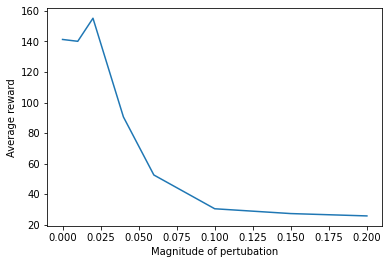

In [6]:
epsilons_attacks = [0,0.01,0.02,0.04,0.06,0.10,0.15,0.20]
plt.ioff()
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()

## Training with adversarial training (only run if you want to train again)

In [7]:
def train_robust(agent_robust, EPSILON_PERT):
    agent_robust.network.train()

    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []


    for i in range(1, EPISODES):
        epsilon_pertubated = max(EPSILON_PERT/(EPISODES - 1.5*i), EPSILON_PERT)
        state = env.reset()
        score = 0
        while True:
            pert_state = attack_FGSM(state, epsilon_pertubated, agent_robust)
            action, q_values = agent_robust.choose_action(pert_state)
            state_, reward, done, info = env.step(action)


            agent_robust.memory.add(state, action, reward, state_, done)
            agent_robust.learn()
            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
            average_reward_number.append(average_reward/i)

In [8]:
robust_agent_1 = DQN_Solver()
robust_agent_2 = DQN_Solver()
robust_agent_3 = DQN_Solver()
robust_agent_4 = DQN_Solver()

agents = [[robust_agent_1,0.01],[robust_agent_2, 0.02], [robust_agent_3, 0.04], [robust_agent_4, 0.06]]
for agent, eps in agents:
    print("NOW TRAINING AGENT WITH EPS:", eps)
    train_robust(agent, eps)

/tmp/ipykernel_421/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


NOW TRAINING AGENT WITH EPS: 0.01
Episode 1 Average Reward 54.0 Best Reward 54.0 Last Reward 54.0 Epsilon 0.9772512378214517
Episode 2 Average Reward 43.0 Best Reward 54.0 Last Reward 32.0 Epsilon 0.946459102605027
Episode 3 Average Reward 32.666666666666664 Best Reward 54.0 Last Reward 12.0 Epsilon 0.9351638519212846
Episode 4 Average Reward 36.5 Best Reward 54.0 Last Reward 48.0 Epsilon 0.8913148576343527
Episode 5 Average Reward 35.8 Best Reward 54.0 Last Reward 33.0 Epsilon 0.862367254825433
Episode 6 Average Reward 33.0 Best Reward 54.0 Last Reward 19.0 Epsilon 0.8461289094829862
Episode 7 Average Reward 30.0 Best Reward 54.0 Last Reward 12.0 Epsilon 0.8360310213470206
Episode 8 Average Reward 27.625 Best Reward 54.0 Last Reward 11.0 Epsilon 0.8268805241487632
Episode 9 Average Reward 25.666666666666668 Best Reward 54.0 Last Reward 10.0 Epsilon 0.818648829478636
Episode 10 Average Reward 24.4 Best Reward 54.0 Last Reward 13.0 Epsilon 0.8080700157548294
Episode 11 Average Reward 23

Episode 82 Average Reward 164.3780487804878 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 83 Average Reward 166.25301204819277 Best Reward 500.0 Last Reward 320.0 Epsilon 0.001
Episode 84 Average Reward 168.39285714285714 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 85 Average Reward 169.83529411764707 Best Reward 500.0 Last Reward 291.0 Epsilon 0.001
Episode 86 Average Reward 171.98837209302326 Best Reward 500.0 Last Reward 355.0 Epsilon 0.001
Episode 87 Average Reward 172.98850574712642 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 88 Average Reward 174.125 Best Reward 500.0 Last Reward 273.0 Epsilon 0.001
Episode 89 Average Reward 175.59550561797752 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 90 Average Reward 176.84444444444443 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 91 Average Reward 178.6153846153846 Best Reward 500.0 Last Reward 338.0 Epsilon 0.001
Episode 92 Average Reward 180.3804347826087 Best Reward 500.0 L

Episode 169 Average Reward 243.81065088757396 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 170 Average Reward 244.56470588235294 Best Reward 500.0 Last Reward 372.0 Epsilon 0.001
Episode 171 Average Reward 245.49707602339183 Best Reward 500.0 Last Reward 404.0 Epsilon 0.001
Episode 172 Average Reward 246.13372093023256 Best Reward 500.0 Last Reward 355.0 Epsilon 0.001
Episode 173 Average Reward 245.6878612716763 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 174 Average Reward 245.83333333333334 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 175 Average Reward 245.71428571428572 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 176 Average Reward 245.85795454545453 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 177 Average Reward 245.85310734463278 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 178 Average Reward 245.56179775280899 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 179 Average Reward 245.4860335195

Episode 256 Average Reward 261.96875 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 257 Average Reward 262.3112840466926 Best Reward 500.0 Last Reward 350.0 Epsilon 0.001
Episode 258 Average Reward 262.30232558139534 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 259 Average Reward 263.2200772200772 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 260 Average Reward 263.4807692307692 Best Reward 500.0 Last Reward 331.0 Epsilon 0.001
Episode 261 Average Reward 263.7701149425287 Best Reward 500.0 Last Reward 339.0 Epsilon 0.001
Episode 262 Average Reward 264.0 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 263 Average Reward 264.41444866920153 Best Reward 500.0 Last Reward 373.0 Epsilon 0.001
Episode 264 Average Reward 264.5037878787879 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 265 Average Reward 265.1283018867924 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 266 Average Reward 266.0112781954887 Best Reward 500.0 Last 

Episode 344 Average Reward 216.9360465116279 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 345 Average Reward 216.56811594202898 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 346 Average Reward 216.4508670520231 Best Reward 500.0 Last Reward 176.0 Epsilon 0.001
Episode 347 Average Reward 216.26512968299713 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 348 Average Reward 216.29022988505747 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 349 Average Reward 215.9111747851003 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 350 Average Reward 215.53142857142856 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 351 Average Reward 215.1937321937322 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 352 Average Reward 214.875 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 353 Average Reward 214.68555240793202 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 354 Average Reward 215.28813559322035 Best Reward 5

Episode 430 Average Reward 250.56279069767442 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 431 Average Reward 250.5614849187935 Best Reward 500.0 Last Reward 250.0 Epsilon 0.001
Episode 432 Average Reward 250.63888888888889 Best Reward 500.0 Last Reward 284.0 Epsilon 0.001
Episode 433 Average Reward 250.4226327944573 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 434 Average Reward 250.99769585253455 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 435 Average Reward 251.23218390804598 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 436 Average Reward 251.12614678899084 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 437 Average Reward 251.0938215102975 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 438 Average Reward 250.96118721461187 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 439 Average Reward 251.00683371298405 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 440 Average Reward 250.836363636363

Episode 18 Average Reward 21.5 Best Reward 45.0 Last Reward 36.0 Epsilon 0.7003478640347469
Episode 19 Average Reward 20.94736842105263 Best Reward 45.0 Last Reward 11.0 Epsilon 0.6926824413362807
Episode 20 Average Reward 21.05 Best Reward 45.0 Last Reward 23.0 Epsilon 0.6769247732130653
Episode 21 Average Reward 20.904761904761905 Best Reward 45.0 Last Reward 18.0 Epsilon 0.6648431464805192
Episode 22 Average Reward 20.5 Best Reward 45.0 Last Reward 12.0 Epsilon 0.6569087624334999
Episode 23 Average Reward 21.695652173913043 Best Reward 48.0 Last Reward 48.0 Epsilon 0.6261068997312542
Episode 24 Average Reward 21.75 Best Reward 48.0 Last Reward 23.0 Epsilon 0.6118637427709198
Episode 25 Average Reward 22.04 Best Reward 48.0 Last Reward 29.0 Epsilon 0.5943658896200158
Episode 26 Average Reward 23.115384615384617 Best Reward 50.0 Last Reward 50.0 Epsilon 0.5653641794148941
Episode 27 Average Reward 23.444444444444443 Best Reward 50.0 Last Reward 32.0 Epsilon 0.547550162317433
Episode 2

Episode 102 Average Reward 228.4313725490196 Best Reward 500.0 Last Reward 388.0 Epsilon 0.001
Episode 103 Average Reward 228.96116504854368 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 104 Average Reward 229.21153846153845 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 105 Average Reward 230.33333333333334 Best Reward 500.0 Last Reward 347.0 Epsilon 0.001
Episode 106 Average Reward 230.82075471698113 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 107 Average Reward 231.73831775700936 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 108 Average Reward 233.13888888888889 Best Reward 500.0 Last Reward 383.0 Epsilon 0.001
Episode 109 Average Reward 234.1834862385321 Best Reward 500.0 Last Reward 347.0 Epsilon 0.001
Episode 110 Average Reward 235.3272727272727 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 111 Average Reward 235.93693693693695 Best Reward 500.0 Last Reward 303.0 Epsilon 0.001
Episode 112 Average Reward 236.508928571428

Episode 188 Average Reward 227.2340425531915 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 189 Average Reward 227.07407407407408 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 190 Average Reward 226.62105263157895 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 191 Average Reward 226.17277486910996 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 192 Average Reward 226.15625 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 193 Average Reward 226.53886010362694 Best Reward 500.0 Last Reward 300.0 Epsilon 0.001
Episode 194 Average Reward 226.0979381443299 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 195 Average Reward 225.83076923076922 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 196 Average Reward 225.3826530612245 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 197 Average Reward 226.38071065989848 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 198 Average Reward 226.08585858585857 Best R

Episode 275 Average Reward 258.3018181818182 Best Reward 500.0 Last Reward 493.0 Epsilon 0.001
Episode 276 Average Reward 259.17753623188406 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 277 Average Reward 258.86281588447656 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 278 Average Reward 259.73021582733816 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 279 Average Reward 260.59139784946234 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 280 Average Reward 261.44642857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 281 Average Reward 260.7330960854093 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 282 Average Reward 259.98581560283685 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 283 Average Reward 260.8339222614841 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 284 Average Reward 261.07042253521126 Best Reward 500.0 Last Reward 328.0 Epsilon 0.001
Episode 285 Average Reward 261.0175438596491 

Episode 362 Average Reward 256.5 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 363 Average Reward 256.43250688705234 Best Reward 500.0 Last Reward 232.0 Epsilon 0.001
Episode 364 Average Reward 256.7142857142857 Best Reward 500.0 Last Reward 359.0 Epsilon 0.001
Episode 365 Average Reward 256.44931506849315 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 366 Average Reward 256.25136612021856 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 367 Average Reward 256.91553133514986 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 368 Average Reward 257.57608695652175 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 369 Average Reward 257.12737127371275 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 370 Average Reward 256.8378378378378 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 371 Average Reward 256.55256064690025 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 372 Average Reward 257.2069892473118 Best Reward

Episode 449 Average Reward 257.38975501113583 Best Reward 500.0 Last Reward 295.0 Epsilon 0.001
Episode 450 Average Reward 257.2888888888889 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 451 Average Reward 257.8270509977827 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 452 Average Reward 258.3628318584071 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 453 Average Reward 258.67328918322295 Best Reward 500.0 Last Reward 399.0 Epsilon 0.001
Episode 454 Average Reward 258.1806167400881 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 455 Average Reward 257.92087912087914 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 456 Average Reward 257.9166666666667 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 457 Average Reward 258.4463894967177 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 458 Average Reward 258.9737991266376 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 459 Average Reward 259.45098039215685 Be

Episode 34 Average Reward 16.794117647058822 Best Reward 38.0 Last Reward 12.0 Epsilon 0.5825908266400397
Episode 35 Average Reward 16.714285714285715 Best Reward 38.0 Last Reward 14.0 Epsilon 0.5744873593512512
Episode 36 Average Reward 16.555555555555557 Best Reward 38.0 Last Reward 11.0 Epsilon 0.5681995006020529
Episode 37 Average Reward 16.486486486486488 Best Reward 38.0 Last Reward 14.0 Epsilon 0.5602962074911925
Episode 38 Average Reward 16.63157894736842 Best Reward 38.0 Last Reward 22.0 Epsilon 0.548098260578011
Episode 39 Average Reward 16.487179487179485 Best Reward 38.0 Last Reward 11.0 Epsilon 0.5420992348603912
Episode 40 Average Reward 16.475 Best Reward 38.0 Last Reward 16.0 Epsilon 0.5334903964194936
Episode 41 Average Reward 16.4390243902439 Best Reward 38.0 Last Reward 15.0 Epsilon 0.5255438149533099
Episode 42 Average Reward 16.285714285714285 Best Reward 38.0 Last Reward 10.0 Epsilon 0.5203119633204238
Episode 43 Average Reward 16.348837209302324 Best Reward 38.0 

Episode 115 Average Reward 125.2 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 116 Average Reward 125.76724137931035 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 117 Average Reward 127.01709401709402 Best Reward 500.0 Last Reward 272.0 Epsilon 0.001
Episode 118 Average Reward 130.17796610169492 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 119 Average Reward 131.61344537815125 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 120 Average Reward 133.04166666666666 Best Reward 500.0 Last Reward 303.0 Epsilon 0.001
Episode 121 Average Reward 135.02479338842974 Best Reward 500.0 Last Reward 373.0 Epsilon 0.001
Episode 122 Average Reward 136.09016393442624 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 123 Average Reward 138.91869918699186 Best Reward 500.0 Last Reward 484.0 Epsilon 0.001
Episode 124 Average Reward 139.58870967741936 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 125 Average Reward 140.608 Best Reward 500.0 

Episode 202 Average Reward 177.9108910891089 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 203 Average Reward 177.78817733990147 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 204 Average Reward 178.02941176470588 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 205 Average Reward 178.09268292682927 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 206 Average Reward 178.626213592233 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 207 Average Reward 178.7246376811594 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 208 Average Reward 178.78846153846155 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 209 Average Reward 178.74162679425837 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 210 Average Reward 178.76190476190476 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 211 Average Reward 178.88151658767774 Best Reward 500.0 Last Reward 204.0 Epsilon 0.001
Episode 212 Average Reward 178.9103773584905

Episode 288 Average Reward 191.26736111111111 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 289 Average Reward 191.09342560553634 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 290 Average Reward 191.16206896551725 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 291 Average Reward 191.12027491408935 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 292 Average Reward 191.21575342465752 Best Reward 500.0 Last Reward 219.0 Epsilon 0.001
Episode 293 Average Reward 191.33788395904438 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 294 Average Reward 191.76190476190476 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 295 Average Reward 191.8779661016949 Best Reward 500.0 Last Reward 226.0 Epsilon 0.001
Episode 296 Average Reward 192.9189189189189 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 297 Average Reward 193.1010101010101 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 298 Average Reward 193.100671140939

Episode 375 Average Reward 194.30933333333334 Best Reward 500.0 Last Reward 332.0 Epsilon 0.001
Episode 376 Average Reward 194.08510638297872 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 377 Average Reward 193.9522546419098 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 378 Average Reward 193.94444444444446 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 379 Average Reward 193.80211081794195 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 380 Average Reward 193.7078947368421 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 381 Average Reward 193.76377952755905 Best Reward 500.0 Last Reward 215.0 Epsilon 0.001
Episode 382 Average Reward 193.90314136125656 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 383 Average Reward 194.13577023498695 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 384 Average Reward 194.8046875 Best Reward 500.0 Last Reward 451.0 Epsilon 0.001
Episode 385 Average Reward 194.6987012987013 Best

Episode 462 Average Reward 191.7056277056277 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 463 Average Reward 191.63066954643628 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 464 Average Reward 191.51939655172413 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 465 Average Reward 191.44301075268817 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 466 Average Reward 191.32403433476395 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 467 Average Reward 191.67665952890792 Best Reward 500.0 Last Reward 356.0 Epsilon 0.001
Episode 468 Average Reward 191.5405982905983 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 469 Average Reward 191.4818763326226 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 470 Average Reward 191.4723404255319 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 471 Average Reward 191.87898089171975 Best Reward 500.0 Last Reward 383.0 Epsilon 0.001
Episode 472 Average Reward 192.25 Best Reward

Episode 47 Average Reward 29.638297872340427 Best Reward 95.0 Last Reward 95.0 Epsilon 0.25597347469571885
Episode 48 Average Reward 32.291666666666664 Best Reward 157.0 Last Reward 157.0 Epsilon 0.21876438263583933
Episode 49 Average Reward 32.89795918367347 Best Reward 157.0 Last Reward 62.0 Epsilon 0.20560652132536425
Episode 50 Average Reward 37.18 Best Reward 247.0 Last Reward 247.0 Epsilon 0.16058777361462884
Episode 51 Average Reward 41.372549019607845 Best Reward 251.0 Last Reward 251.0 Epsilon 0.12492519091449104
Episode 52 Average Reward 45.65384615384615 Best Reward 264.0 Last Reward 264.0 Epsilon 0.09592656946698286
Episode 53 Average Reward 54.22641509433962 Best Reward 500.0 Last Reward 500.0 Epsilon 0.05816785197754229
Episode 54 Average Reward 56.98148148148148 Best Reward 500.0 Last Reward 203.0 Epsilon 0.047476329612410224
Episode 55 Average Reward 60.43636363636364 Best Reward 500.0 Last Reward 247.0 Epsilon 0.03708111018417729
Episode 56 Average Reward 65.4642857142

Episode 132 Average Reward 186.18939393939394 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 133 Average Reward 186.33834586466165 Best Reward 500.0 Last Reward 206.0 Epsilon 0.001
Episode 134 Average Reward 186.38805970149255 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 135 Average Reward 186.94074074074075 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 136 Average Reward 186.6764705882353 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 137 Average Reward 187.32116788321167 Best Reward 500.0 Last Reward 275.0 Epsilon 0.001
Episode 138 Average Reward 187.2608695652174 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 139 Average Reward 187.66187050359713 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 140 Average Reward 188.79285714285714 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 141 Average Reward 188.41843971631207 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 142 Average Reward 188.52816901408

Episode 219 Average Reward 176.7579908675799 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 220 Average Reward 176.6727272727273 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 221 Average Reward 176.49773755656108 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 222 Average Reward 176.34234234234233 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 223 Average Reward 176.92376681614348 Best Reward 500.0 Last Reward 306.0 Epsilon 0.001
Episode 224 Average Reward 177.76339285714286 Best Reward 500.0 Last Reward 365.0 Epsilon 0.001
Episode 225 Average Reward 177.50222222222223 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 226 Average Reward 177.22566371681415 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 227 Average Reward 177.15418502202644 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 228 Average Reward 176.8815789473684 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 229 Average Reward 176.8034934497816

Episode 306 Average Reward 161.87581699346404 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 307 Average Reward 161.71335504885994 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 308 Average Reward 161.5681818181818 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 309 Average Reward 161.46278317152104 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 310 Average Reward 161.40645161290323 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 311 Average Reward 161.3183279742765 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 312 Average Reward 161.13141025641025 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 313 Average Reward 160.93290734824282 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 314 Average Reward 160.76433121019107 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 315 Average Reward 160.5936507936508 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 316 Average Reward 160.3417721518987

Episode 393 Average Reward 151.59541984732823 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 394 Average Reward 151.48730964467006 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 395 Average Reward 151.38227848101266 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 396 Average Reward 151.27272727272728 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 397 Average Reward 151.23677581863979 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 398 Average Reward 151.11557788944722 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 399 Average Reward 150.9699248120301 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 400 Average Reward 150.855 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 401 Average Reward 150.86034912718205 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 402 Average Reward 150.7462686567164 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 403 Average Reward 150.73449131513647 Best Rew

Episode 480 Average Reward 146.375 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 481 Average Reward 146.33679833679832 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 482 Average Reward 146.2863070539419 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 483 Average Reward 146.0952380952381 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 484 Average Reward 146.099173553719 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 485 Average Reward 145.83917525773197 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 486 Average Reward 145.79423868312756 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 487 Average Reward 145.78439425051334 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 488 Average Reward 145.74795081967213 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 489 Average Reward 145.68302658486706 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 490 Average Reward 145.60816326530613 Best Reward

In [9]:
torch.save(robust_agent_1, "robust_trained_DQN1.pth")
torch.save(robust_agent_2, "robust_trained_DQN2.pth")
torch.save(robust_agent_3, "robust_trained_DQN3.pth")
torch.save(robust_agent_4, "robust_trained_DQN4.pth")

## Testing robust network

In [10]:
robust_agent_1 = torch.load("robust_trained_DQN1.pth")
robust_agent_2 = torch.load("robust_trained_DQN2.pth")
robust_agent_3 = torch.load("robust_trained_DQN3.pth")
robust_agent_4 = torch.load("robust_trained_DQN4.pth")


In [11]:
robust_agents = [robust_agent_1, robust_agent_2,robust_agent_3,robust_agent_4]
robust_average_rewards = []
for agent in robust_agents:
    print("The current agent is", agent)
    average_rewards = test_network(agent)
    robust_average_rewards.append(average_rewards)

The current agent is <__main__.DQN_Solver object at 0x7fb914559490>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 167.0 Best Reward 167.0 Last Reward 167.0 Epsilon 0.001
Episode 2 Average Reward 165.0 Best Reward 167.0 Last Reward 163.0 Epsilon 0.001
Episode 3 Average Reward 165.66666666666666 Best Reward 167.0 Last Reward 167.0 Epsilon 0.001
Episode 4 Average Reward 164.75 Best Reward 167.0 Last Reward 162.0 Epsilon 0.001
Episode 5 Average Reward 166.2 Best Reward 172.0 Last Reward 172.0 Epsilon 0.001
Episode 6 Average Reward 165.33333333333334 Best Reward 172.0 Last Reward 161.0 Epsilon 0.001
Episode 7 Average Reward 165.14285714285714 Best Reward 172.0 Last Reward 164.0 Epsilon 0.001
Episode 8 Average Reward 165.125 Best Reward 172.0 Last Reward 165.0 Epsilon 0.001
Episode 9 Average Reward 165.11111111111111 Best Reward 172.0 Last Reward 165.0 Epsilon 0.001
Episode 10 Average Reward 165.9 Best Reward 173.0 Last Reward 173.0 Epsilon 0.001
Episode 11 Average 

Episode 89 Average Reward 168.02247191011236 Best Reward 182.0 Last Reward 174.0 Epsilon 0.001
Episode 90 Average Reward 167.9777777777778 Best Reward 182.0 Last Reward 164.0 Epsilon 0.001
Episode 91 Average Reward 168.05494505494505 Best Reward 182.0 Last Reward 175.0 Epsilon 0.001
Episode 92 Average Reward 168.02173913043478 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 93 Average Reward 168.06451612903226 Best Reward 182.0 Last Reward 172.0 Epsilon 0.001
Episode 94 Average Reward 168.12765957446808 Best Reward 182.0 Last Reward 174.0 Epsilon 0.001
Episode 95 Average Reward 168.09473684210528 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 96 Average Reward 168.05208333333334 Best Reward 182.0 Last Reward 164.0 Epsilon 0.001
Episode 97 Average Reward 168.0721649484536 Best Reward 182.0 Last Reward 170.0 Epsilon 0.001
Episode 98 Average Reward 168.1122448979592 Best Reward 182.0 Last Reward 172.0 Epsilon 0.001
Episode 99 Average Reward 168.06060606060606 Best Rew

Episode 176 Average Reward 168.3068181818182 Best Reward 182.0 Last Reward 176.0 Epsilon 0.001
Episode 177 Average Reward 168.28813559322035 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 178 Average Reward 168.30337078651687 Best Reward 182.0 Last Reward 171.0 Epsilon 0.001
Episode 179 Average Reward 168.34078212290504 Best Reward 182.0 Last Reward 175.0 Epsilon 0.001
Episode 180 Average Reward 168.32222222222222 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 181 Average Reward 168.32596685082873 Best Reward 182.0 Last Reward 169.0 Epsilon 0.001
Episode 182 Average Reward 168.30769230769232 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 183 Average Reward 168.26775956284152 Best Reward 182.0 Last Reward 161.0 Epsilon 0.001
Episode 184 Average Reward 168.32065217391303 Best Reward 182.0 Last Reward 178.0 Epsilon 0.001
Episode 185 Average Reward 168.3027027027027 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 186 Average Reward 168.28494623655

Episode 14 Average Reward 168.42857142857142 Best Reward 182.0 Last Reward 170.0 Epsilon 0.001
Episode 15 Average Reward 169.06666666666666 Best Reward 182.0 Last Reward 178.0 Epsilon 0.001
Episode 16 Average Reward 169.5625 Best Reward 182.0 Last Reward 177.0 Epsilon 0.001
Episode 17 Average Reward 169.1764705882353 Best Reward 182.0 Last Reward 163.0 Epsilon 0.001
Episode 18 Average Reward 169.5 Best Reward 182.0 Last Reward 175.0 Epsilon 0.001
Episode 19 Average Reward 169.31578947368422 Best Reward 182.0 Last Reward 166.0 Epsilon 0.001
Episode 20 Average Reward 169.25 Best Reward 182.0 Last Reward 168.0 Epsilon 0.001
Episode 21 Average Reward 169.42857142857142 Best Reward 182.0 Last Reward 173.0 Epsilon 0.001
Episode 22 Average Reward 169.45454545454547 Best Reward 182.0 Last Reward 170.0 Epsilon 0.001
Episode 23 Average Reward 169.2608695652174 Best Reward 182.0 Last Reward 165.0 Epsilon 0.001
Episode 24 Average Reward 169.45833333333334 Best Reward 182.0 Last Reward 174.0 Epsilo

Episode 103 Average Reward 171.35922330097088 Best Reward 187.0 Last Reward 164.0 Epsilon 0.001
Episode 104 Average Reward 171.28846153846155 Best Reward 187.0 Last Reward 164.0 Epsilon 0.001
Episode 105 Average Reward 171.31428571428572 Best Reward 187.0 Last Reward 174.0 Epsilon 0.001
Episode 106 Average Reward 171.33962264150944 Best Reward 187.0 Last Reward 174.0 Epsilon 0.001
Episode 107 Average Reward 171.29906542056074 Best Reward 187.0 Last Reward 167.0 Epsilon 0.001
Episode 108 Average Reward 171.30555555555554 Best Reward 187.0 Last Reward 172.0 Epsilon 0.001
Episode 109 Average Reward 171.32110091743118 Best Reward 187.0 Last Reward 173.0 Epsilon 0.001
Episode 110 Average Reward 171.3272727272727 Best Reward 187.0 Last Reward 172.0 Epsilon 0.001
Episode 111 Average Reward 171.3963963963964 Best Reward 187.0 Last Reward 179.0 Epsilon 0.001
Episode 112 Average Reward 171.39285714285714 Best Reward 187.0 Last Reward 171.0 Epsilon 0.001
Episode 113 Average Reward 171.47787610619

Episode 190 Average Reward 171.3 Best Reward 188.0 Last Reward 176.0 Epsilon 0.001
Episode 191 Average Reward 171.31413612565444 Best Reward 188.0 Last Reward 174.0 Epsilon 0.001
Episode 192 Average Reward 171.28645833333334 Best Reward 188.0 Last Reward 166.0 Epsilon 0.001
Episode 193 Average Reward 171.32124352331607 Best Reward 188.0 Last Reward 178.0 Epsilon 0.001
Episode 194 Average Reward 171.340206185567 Best Reward 188.0 Last Reward 175.0 Epsilon 0.001
Episode 195 Average Reward 171.36923076923077 Best Reward 188.0 Last Reward 177.0 Epsilon 0.001
Episode 196 Average Reward 171.41836734693877 Best Reward 188.0 Last Reward 181.0 Epsilon 0.001
Episode 197 Average Reward 171.34010152284264 Best Reward 188.0 Last Reward 156.0 Epsilon 0.001
Episode 198 Average Reward 171.37373737373738 Best Reward 188.0 Last Reward 178.0 Epsilon 0.001
Episode 199 Average Reward 171.3819095477387 Best Reward 188.0 Last Reward 173.0 Epsilon 0.001
Episode 200 Average Reward 171.35 Best Reward 188.0 Last

Episode 29 Average Reward 166.41379310344828 Best Reward 198.0 Last Reward 154.0 Epsilon 0.001
Episode 30 Average Reward 166.86666666666667 Best Reward 198.0 Last Reward 180.0 Epsilon 0.001
Episode 31 Average Reward 166.41935483870967 Best Reward 198.0 Last Reward 153.0 Epsilon 0.001
Episode 32 Average Reward 166.46875 Best Reward 198.0 Last Reward 168.0 Epsilon 0.001
Episode 33 Average Reward 166.87878787878788 Best Reward 198.0 Last Reward 180.0 Epsilon 0.001
Episode 34 Average Reward 167.0 Best Reward 198.0 Last Reward 171.0 Epsilon 0.001
Episode 35 Average Reward 167.0857142857143 Best Reward 198.0 Last Reward 170.0 Epsilon 0.001
Episode 36 Average Reward 167.66666666666666 Best Reward 198.0 Last Reward 188.0 Epsilon 0.001
Episode 37 Average Reward 167.51351351351352 Best Reward 198.0 Last Reward 162.0 Epsilon 0.001
Episode 38 Average Reward 167.6578947368421 Best Reward 198.0 Last Reward 173.0 Epsilon 0.001
Episode 39 Average Reward 168.15384615384616 Best Reward 198.0 Last Reward

Episode 117 Average Reward 168.2051282051282 Best Reward 198.0 Last Reward 161.0 Epsilon 0.001
Episode 118 Average Reward 168.16101694915255 Best Reward 198.0 Last Reward 163.0 Epsilon 0.001
Episode 119 Average Reward 168.10084033613447 Best Reward 198.0 Last Reward 161.0 Epsilon 0.001
Episode 120 Average Reward 168.05 Best Reward 198.0 Last Reward 162.0 Epsilon 0.001
Episode 121 Average Reward 168.05785123966942 Best Reward 198.0 Last Reward 169.0 Epsilon 0.001
Episode 122 Average Reward 168.0 Best Reward 198.0 Last Reward 161.0 Epsilon 0.001
Episode 123 Average Reward 167.9918699186992 Best Reward 198.0 Last Reward 167.0 Epsilon 0.001
Episode 124 Average Reward 168.08064516129033 Best Reward 198.0 Last Reward 179.0 Epsilon 0.001
Episode 125 Average Reward 168.048 Best Reward 198.0 Last Reward 164.0 Epsilon 0.001
Episode 126 Average Reward 168.21428571428572 Best Reward 198.0 Last Reward 189.0 Epsilon 0.001
Episode 127 Average Reward 168.1968503937008 Best Reward 198.0 Last Reward 166

Episode 204 Average Reward 167.9656862745098 Best Reward 198.0 Last Reward 162.0 Epsilon 0.001
Episode 205 Average Reward 167.9658536585366 Best Reward 198.0 Last Reward 168.0 Epsilon 0.001
Episode 206 Average Reward 167.9126213592233 Best Reward 198.0 Last Reward 157.0 Epsilon 0.001
Episode 207 Average Reward 167.91787439613526 Best Reward 198.0 Last Reward 169.0 Epsilon 0.001
Episode 208 Average Reward 167.91346153846155 Best Reward 198.0 Last Reward 167.0 Epsilon 0.001
Episode 209 Average Reward 167.95693779904306 Best Reward 198.0 Last Reward 177.0 Epsilon 0.001
Episode 210 Average Reward 167.94761904761904 Best Reward 198.0 Last Reward 166.0 Epsilon 0.001
Episode 211 Average Reward 167.87677725118485 Best Reward 198.0 Last Reward 153.0 Epsilon 0.001
Episode 212 Average Reward 167.8443396226415 Best Reward 198.0 Last Reward 161.0 Epsilon 0.001
Episode 213 Average Reward 167.92018779342723 Best Reward 198.0 Last Reward 184.0 Epsilon 0.001
Episode 214 Average Reward 167.8878504672897

Episode 43 Average Reward 142.09302325581396 Best Reward 201.0 Last Reward 137.0 Epsilon 0.001
Episode 44 Average Reward 142.20454545454547 Best Reward 201.0 Last Reward 147.0 Epsilon 0.001
Episode 45 Average Reward 142.13333333333333 Best Reward 201.0 Last Reward 139.0 Epsilon 0.001
Episode 46 Average Reward 143.2391304347826 Best Reward 201.0 Last Reward 193.0 Epsilon 0.001
Episode 47 Average Reward 144.27659574468086 Best Reward 201.0 Last Reward 192.0 Epsilon 0.001
Episode 48 Average Reward 143.97916666666666 Best Reward 201.0 Last Reward 130.0 Epsilon 0.001
Episode 49 Average Reward 143.83673469387756 Best Reward 201.0 Last Reward 137.0 Epsilon 0.001
Episode 50 Average Reward 143.7 Best Reward 201.0 Last Reward 137.0 Epsilon 0.001
Episode 51 Average Reward 143.52941176470588 Best Reward 201.0 Last Reward 135.0 Epsilon 0.001
Episode 52 Average Reward 143.3846153846154 Best Reward 201.0 Last Reward 136.0 Epsilon 0.001
Episode 53 Average Reward 143.18867924528303 Best Reward 201.0 La

Episode 131 Average Reward 144.70992366412213 Best Reward 243.0 Last Reward 107.0 Epsilon 0.001
Episode 132 Average Reward 144.71212121212122 Best Reward 243.0 Last Reward 145.0 Epsilon 0.001
Episode 133 Average Reward 144.65413533834587 Best Reward 243.0 Last Reward 137.0 Epsilon 0.001
Episode 134 Average Reward 144.83582089552237 Best Reward 243.0 Last Reward 169.0 Epsilon 0.001
Episode 135 Average Reward 144.8 Best Reward 243.0 Last Reward 140.0 Epsilon 0.001
Episode 136 Average Reward 144.97794117647058 Best Reward 243.0 Last Reward 169.0 Epsilon 0.001
Episode 137 Average Reward 144.91970802919707 Best Reward 243.0 Last Reward 137.0 Epsilon 0.001
Episode 138 Average Reward 144.94927536231884 Best Reward 243.0 Last Reward 149.0 Epsilon 0.001
Episode 139 Average Reward 144.79856115107913 Best Reward 243.0 Last Reward 124.0 Epsilon 0.001
Episode 140 Average Reward 144.89285714285714 Best Reward 243.0 Last Reward 158.0 Epsilon 0.001
Episode 141 Average Reward 144.8581560283688 Best Rew

Episode 218 Average Reward 145.40825688073394 Best Reward 244.0 Last Reward 133.0 Epsilon 0.001
Episode 219 Average Reward 145.3744292237443 Best Reward 244.0 Last Reward 138.0 Epsilon 0.001
Episode 220 Average Reward 145.29090909090908 Best Reward 244.0 Last Reward 127.0 Epsilon 0.001
Episode 221 Average Reward 145.24886877828055 Best Reward 244.0 Last Reward 136.0 Epsilon 0.001
Episode 222 Average Reward 145.22972972972974 Best Reward 244.0 Last Reward 141.0 Epsilon 0.001
Episode 223 Average Reward 145.3273542600897 Best Reward 244.0 Last Reward 167.0 Epsilon 0.001
Episode 224 Average Reward 145.36160714285714 Best Reward 244.0 Last Reward 153.0 Epsilon 0.001
Episode 225 Average Reward 145.32444444444445 Best Reward 244.0 Last Reward 137.0 Epsilon 0.001
Episode 226 Average Reward 145.2920353982301 Best Reward 244.0 Last Reward 138.0 Epsilon 0.001
Episode 227 Average Reward 145.2202643171806 Best Reward 244.0 Last Reward 129.0 Epsilon 0.001
Episode 228 Average Reward 145.1710526315789

Episode 57 Average Reward 163.19298245614036 Best Reward 359.0 Last Reward 162.0 Epsilon 0.001
Episode 58 Average Reward 161.70689655172413 Best Reward 359.0 Last Reward 77.0 Epsilon 0.001
Episode 59 Average Reward 162.25423728813558 Best Reward 359.0 Last Reward 194.0 Epsilon 0.001
Episode 60 Average Reward 161.81666666666666 Best Reward 359.0 Last Reward 136.0 Epsilon 0.001
Episode 61 Average Reward 161.39344262295083 Best Reward 359.0 Last Reward 136.0 Epsilon 0.001
Episode 62 Average Reward 160.66129032258064 Best Reward 359.0 Last Reward 116.0 Epsilon 0.001
Episode 63 Average Reward 160.3015873015873 Best Reward 359.0 Last Reward 138.0 Epsilon 0.001
Episode 64 Average Reward 160.59375 Best Reward 359.0 Last Reward 179.0 Epsilon 0.001
Episode 65 Average Reward 160.7076923076923 Best Reward 359.0 Last Reward 168.0 Epsilon 0.001
Episode 66 Average Reward 161.06060606060606 Best Reward 359.0 Last Reward 184.0 Epsilon 0.001
Episode 67 Average Reward 161.91044776119404 Best Reward 359.0

Episode 144 Average Reward 159.97222222222223 Best Reward 359.0 Last Reward 133.0 Epsilon 0.001
Episode 145 Average Reward 159.83448275862068 Best Reward 359.0 Last Reward 140.0 Epsilon 0.001
Episode 146 Average Reward 158.96575342465752 Best Reward 359.0 Last Reward 33.0 Epsilon 0.001
Episode 147 Average Reward 158.85034013605443 Best Reward 359.0 Last Reward 142.0 Epsilon 0.001
Episode 148 Average Reward 159.10135135135135 Best Reward 359.0 Last Reward 196.0 Epsilon 0.001
Episode 149 Average Reward 158.88590604026845 Best Reward 359.0 Last Reward 127.0 Epsilon 0.001
Episode 150 Average Reward 158.94666666666666 Best Reward 359.0 Last Reward 168.0 Epsilon 0.001
Episode 151 Average Reward 158.66887417218544 Best Reward 359.0 Last Reward 117.0 Epsilon 0.001
Episode 152 Average Reward 158.82236842105263 Best Reward 359.0 Last Reward 182.0 Epsilon 0.001
Episode 153 Average Reward 158.94117647058823 Best Reward 359.0 Last Reward 177.0 Epsilon 0.001
Episode 154 Average Reward 159.5454545454

Episode 231 Average Reward 158.6103896103896 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 232 Average Reward 158.61637931034483 Best Reward 359.0 Last Reward 160.0 Epsilon 0.001
Episode 233 Average Reward 158.66523605150215 Best Reward 359.0 Last Reward 170.0 Epsilon 0.001
Episode 234 Average Reward 158.5 Best Reward 359.0 Last Reward 120.0 Epsilon 0.001
Episode 235 Average Reward 158.54468085106382 Best Reward 359.0 Last Reward 169.0 Epsilon 0.001
Episode 236 Average Reward 158.16101694915255 Best Reward 359.0 Last Reward 68.0 Epsilon 0.001
Episode 237 Average Reward 158.08860759493672 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 238 Average Reward 158.03781512605042 Best Reward 359.0 Last Reward 146.0 Epsilon 0.001
Episode 239 Average Reward 158.06276150627616 Best Reward 359.0 Last Reward 164.0 Epsilon 0.001
Episode 240 Average Reward 157.95416666666668 Best Reward 359.0 Last Reward 132.0 Epsilon 0.001
Episode 241 Average Reward 157.99170124481327 Best Rewa

Episode 71 Average Reward 120.35211267605634 Best Reward 359.0 Last Reward 143.0 Epsilon 0.001
Episode 72 Average Reward 120.625 Best Reward 359.0 Last Reward 140.0 Epsilon 0.001
Episode 73 Average Reward 119.83561643835617 Best Reward 359.0 Last Reward 63.0 Epsilon 0.001
Episode 74 Average Reward 120.10810810810811 Best Reward 359.0 Last Reward 140.0 Epsilon 0.001
Episode 75 Average Reward 120.38666666666667 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 76 Average Reward 118.97368421052632 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 77 Average Reward 119.25974025974025 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 78 Average Reward 119.67948717948718 Best Reward 359.0 Last Reward 152.0 Epsilon 0.001
Episode 79 Average Reward 120.20253164556962 Best Reward 359.0 Last Reward 161.0 Epsilon 0.001
Episode 80 Average Reward 120.525 Best Reward 359.0 Last Reward 146.0 Epsilon 0.001
Episode 81 Average Reward 120.87654320987654 Best Reward 359.0 Last Reward

Episode 159 Average Reward 119.37735849056604 Best Reward 359.0 Last Reward 143.0 Epsilon 0.001
Episode 160 Average Reward 119.55 Best Reward 359.0 Last Reward 147.0 Epsilon 0.001
Episode 161 Average Reward 119.72049689440993 Best Reward 359.0 Last Reward 147.0 Epsilon 0.001
Episode 162 Average Reward 119.89506172839506 Best Reward 359.0 Last Reward 148.0 Epsilon 0.001
Episode 163 Average Reward 119.25153374233129 Best Reward 359.0 Last Reward 15.0 Epsilon 0.001
Episode 164 Average Reward 119.39634146341463 Best Reward 359.0 Last Reward 143.0 Epsilon 0.001
Episode 165 Average Reward 119.53333333333333 Best Reward 359.0 Last Reward 142.0 Epsilon 0.001
Episode 166 Average Reward 119.66265060240964 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 167 Average Reward 119.83233532934132 Best Reward 359.0 Last Reward 148.0 Epsilon 0.001
Episode 168 Average Reward 119.98214285714286 Best Reward 359.0 Last Reward 145.0 Epsilon 0.001
Episode 169 Average Reward 120.11242603550296 Best Re

Episode 246 Average Reward 124.16666666666667 Best Reward 359.0 Last Reward 140.0 Epsilon 0.001
Episode 247 Average Reward 124.22672064777328 Best Reward 359.0 Last Reward 139.0 Epsilon 0.001
Episode 248 Average Reward 124.29435483870968 Best Reward 359.0 Last Reward 141.0 Epsilon 0.001
Episode 249 Average Reward 124.34939759036145 Best Reward 359.0 Last Reward 138.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.15
Episode 1 Average Reward 11.0 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 2 Average Reward 60.5 Best Reward 359.0 Last Reward 110.0 Epsilon 0.001
Episode 3 Average Reward 46.0 Best Reward 359.0 Last Reward 17.0 Epsilon 0.001
Episode 4 Average Reward 38.75 Best Reward 359.0 Last Reward 17.0 Epsilon 0.001
Episode 5 Average Reward 53.8 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 6 Average Reward 47.666666666666664 Best Reward 359.0 Last Reward 17.0 Epsilon 0.001
Episode 7 Average Reward 43.142857142857146 Best Reward 359.0 Last Reward 1

Episode 89 Average Reward 68.86516853932584 Best Reward 359.0 Last Reward 113.0 Epsilon 0.001
Episode 90 Average Reward 68.25555555555556 Best Reward 359.0 Last Reward 14.0 Epsilon 0.001
Episode 91 Average Reward 67.71428571428571 Best Reward 359.0 Last Reward 19.0 Epsilon 0.001
Episode 92 Average Reward 68.21739130434783 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 93 Average Reward 67.61290322580645 Best Reward 359.0 Last Reward 12.0 Epsilon 0.001
Episode 94 Average Reward 68.09574468085107 Best Reward 359.0 Last Reward 113.0 Epsilon 0.001
Episode 95 Average Reward 68.57894736842105 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 96 Average Reward 69.05208333333333 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 97 Average Reward 68.49484536082474 Best Reward 359.0 Last Reward 15.0 Epsilon 0.001
Episode 98 Average Reward 67.94897959183673 Best Reward 359.0 Last Reward 15.0 Epsilon 0.001
Episode 99 Average Reward 68.43434343434343 Best Reward 359.0 Las

Episode 177 Average Reward 70.70621468926554 Best Reward 359.0 Last Reward 115.0 Epsilon 0.001
Episode 178 Average Reward 70.96067415730337 Best Reward 359.0 Last Reward 116.0 Epsilon 0.001
Episode 179 Average Reward 71.21787709497207 Best Reward 359.0 Last Reward 117.0 Epsilon 0.001
Episode 180 Average Reward 71.45555555555555 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 181 Average Reward 71.66298342541437 Best Reward 359.0 Last Reward 109.0 Epsilon 0.001
Episode 182 Average Reward 71.35164835164835 Best Reward 359.0 Last Reward 15.0 Epsilon 0.001
Episode 183 Average Reward 71.0327868852459 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 184 Average Reward 71.2663043478261 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 185 Average Reward 71.4972972972973 Best Reward 359.0 Last Reward 114.0 Epsilon 0.001
Episode 186 Average Reward 71.73118279569893 Best Reward 359.0 Last Reward 115.0 Epsilon 0.001
Episode 187 Average Reward 71.43850267379679 Best Rewar

Episode 24 Average Reward 12.083333333333334 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 25 Average Reward 12.12 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 26 Average Reward 12.115384615384615 Best Reward 359.0 Last Reward 12.0 Epsilon 0.001
Episode 27 Average Reward 12.148148148148149 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 28 Average Reward 12.214285714285714 Best Reward 359.0 Last Reward 14.0 Epsilon 0.001
Episode 29 Average Reward 12.275862068965518 Best Reward 359.0 Last Reward 14.0 Epsilon 0.001
Episode 30 Average Reward 12.3 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 31 Average Reward 12.32258064516129 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 32 Average Reward 12.28125 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 33 Average Reward 12.242424242424242 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 34 Average Reward 12.205882352941176 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Epis

Episode 114 Average Reward 12.31578947368421 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 115 Average Reward 12.304347826086957 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 116 Average Reward 12.310344827586206 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 117 Average Reward 12.2991452991453 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 118 Average Reward 12.288135593220339 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 119 Average Reward 12.277310924369749 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 120 Average Reward 12.266666666666667 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 121 Average Reward 12.28099173553719 Best Reward 359.0 Last Reward 14.0 Epsilon 0.001
Episode 122 Average Reward 12.254098360655737 Best Reward 359.0 Last Reward 9.0 Epsilon 0.001
Episode 123 Average Reward 12.276422764227643 Best Reward 359.0 Last Reward 15.0 Epsilon 0.001
Episode 124 Average Reward 12.274193548387096 Best Rewa

Episode 206 Average Reward 12.29126213592233 Best Reward 359.0 Last Reward 14.0 Epsilon 0.001
Episode 207 Average Reward 12.285024154589372 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 208 Average Reward 12.288461538461538 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 209 Average Reward 12.291866028708133 Best Reward 359.0 Last Reward 13.0 Epsilon 0.001
Episode 210 Average Reward 12.290476190476191 Best Reward 359.0 Last Reward 12.0 Epsilon 0.001
Episode 211 Average Reward 12.28436018957346 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 212 Average Reward 12.283018867924529 Best Reward 359.0 Last Reward 12.0 Epsilon 0.001
Episode 213 Average Reward 12.28169014084507 Best Reward 359.0 Last Reward 12.0 Epsilon 0.001
Episode 214 Average Reward 12.27570093457944 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 215 Average Reward 12.269767441860465 Best Reward 359.0 Last Reward 11.0 Epsilon 0.001
Episode 216 Average Reward 12.268518518518519 Best Rew

Episode 45 Average Reward 221.86666666666667 Best Reward 248.0 Last Reward 235.0 Epsilon 0.001
Episode 46 Average Reward 221.6304347826087 Best Reward 248.0 Last Reward 211.0 Epsilon 0.001
Episode 47 Average Reward 221.61702127659575 Best Reward 248.0 Last Reward 221.0 Epsilon 0.001
Episode 48 Average Reward 221.39583333333334 Best Reward 248.0 Last Reward 211.0 Epsilon 0.001
Episode 49 Average Reward 221.14285714285714 Best Reward 248.0 Last Reward 209.0 Epsilon 0.001
Episode 50 Average Reward 221.24 Best Reward 248.0 Last Reward 226.0 Epsilon 0.001
Episode 51 Average Reward 220.76470588235293 Best Reward 248.0 Last Reward 197.0 Epsilon 0.001
Episode 52 Average Reward 221.05769230769232 Best Reward 248.0 Last Reward 236.0 Epsilon 0.001
Episode 53 Average Reward 221.35849056603774 Best Reward 248.0 Last Reward 237.0 Epsilon 0.001
Episode 54 Average Reward 221.90740740740742 Best Reward 251.0 Last Reward 251.0 Epsilon 0.001
Episode 55 Average Reward 221.70909090909092 Best Reward 251.0 

Episode 133 Average Reward 222.203007518797 Best Reward 280.0 Last Reward 215.0 Epsilon 0.001
Episode 134 Average Reward 222.1492537313433 Best Reward 280.0 Last Reward 215.0 Epsilon 0.001
Episode 135 Average Reward 222.2 Best Reward 280.0 Last Reward 229.0 Epsilon 0.001
Episode 136 Average Reward 222.19117647058823 Best Reward 280.0 Last Reward 221.0 Epsilon 0.001
Episode 137 Average Reward 222.21167883211677 Best Reward 280.0 Last Reward 225.0 Epsilon 0.001
Episode 138 Average Reward 222.2463768115942 Best Reward 280.0 Last Reward 227.0 Epsilon 0.001
Episode 139 Average Reward 222.20863309352518 Best Reward 280.0 Last Reward 217.0 Epsilon 0.001
Episode 140 Average Reward 222.22857142857143 Best Reward 280.0 Last Reward 225.0 Epsilon 0.001
Episode 141 Average Reward 222.2340425531915 Best Reward 280.0 Last Reward 223.0 Epsilon 0.001
Episode 142 Average Reward 222.04929577464787 Best Reward 280.0 Last Reward 196.0 Epsilon 0.001
Episode 143 Average Reward 221.87412587412587 Best Reward 

Episode 220 Average Reward 221.6409090909091 Best Reward 280.0 Last Reward 212.0 Epsilon 0.001
Episode 221 Average Reward 221.6787330316742 Best Reward 280.0 Last Reward 230.0 Epsilon 0.001
Episode 222 Average Reward 221.72072072072072 Best Reward 280.0 Last Reward 231.0 Epsilon 0.001
Episode 223 Average Reward 221.7443946188341 Best Reward 280.0 Last Reward 227.0 Epsilon 0.001
Episode 224 Average Reward 221.71428571428572 Best Reward 280.0 Last Reward 215.0 Epsilon 0.001
Episode 225 Average Reward 221.76888888888888 Best Reward 280.0 Last Reward 234.0 Epsilon 0.001
Episode 226 Average Reward 221.6769911504425 Best Reward 280.0 Last Reward 201.0 Epsilon 0.001
Episode 227 Average Reward 221.69162995594715 Best Reward 280.0 Last Reward 225.0 Epsilon 0.001
Episode 228 Average Reward 221.82894736842104 Best Reward 280.0 Last Reward 253.0 Epsilon 0.001
Episode 229 Average Reward 221.7292576419214 Best Reward 280.0 Last Reward 199.0 Epsilon 0.001
Episode 230 Average Reward 221.60434782608695

Episode 59 Average Reward 288.89830508474574 Best Reward 500.0 Last Reward 277.0 Epsilon 0.001
Episode 60 Average Reward 290.01666666666665 Best Reward 500.0 Last Reward 356.0 Epsilon 0.001
Episode 61 Average Reward 288.8032786885246 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 62 Average Reward 287.53225806451616 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 63 Average Reward 287.8888888888889 Best Reward 500.0 Last Reward 310.0 Epsilon 0.001
Episode 64 Average Reward 287.46875 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 65 Average Reward 287.33846153846156 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 66 Average Reward 286.3181818181818 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 67 Average Reward 285.34328358208955 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 68 Average Reward 284.29411764705884 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 69 Average Reward 283.1304347826087 Best Reward 500.0 

Episode 147 Average Reward 280.3061224489796 Best Reward 500.0 Last Reward 366.0 Epsilon 0.001
Episode 148 Average Reward 279.97972972972974 Best Reward 500.0 Last Reward 232.0 Epsilon 0.001
Episode 149 Average Reward 281.4563758389262 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 150 Average Reward 281.14 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 151 Average Reward 282.58940397350995 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 152 Average Reward 282.1118421052632 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 153 Average Reward 281.62091503267976 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 154 Average Reward 281.25324675324674 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 155 Average Reward 280.8451612903226 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 156 Average Reward 280.5833333333333 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 157 Average Reward 280.35668789808915 Best Reward

Episode 234 Average Reward 284.3205128205128 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 235 Average Reward 284.25531914893617 Best Reward 500.0 Last Reward 269.0 Epsilon 0.001
Episode 236 Average Reward 284.1398305084746 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 237 Average Reward 283.9746835443038 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 238 Average Reward 283.718487394958 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 239 Average Reward 283.581589958159 Best Reward 500.0 Last Reward 251.0 Epsilon 0.001
Episode 240 Average Reward 283.8208333333333 Best Reward 500.0 Last Reward 341.0 Epsilon 0.001
Episode 241 Average Reward 283.6721991701245 Best Reward 500.0 Last Reward 248.0 Epsilon 0.001
Episode 242 Average Reward 283.5123966942149 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 243 Average Reward 283.18106995884773 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 244 Average Reward 283.33196721311475 Best

Episode 74 Average Reward 349.86486486486484 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 75 Average Reward 351.8666666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 76 Average Reward 351.25 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 77 Average Reward 353.1818181818182 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 78 Average Reward 355.06410256410254 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 79 Average Reward 354.34177215189874 Best Reward 500.0 Last Reward 298.0 Epsilon 0.001
Episode 80 Average Reward 356.1625 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 81 Average Reward 354.74074074074076 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 82 Average Reward 353.1829268292683 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 83 Average Reward 353.6385542168675 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 84 Average Reward 352.0952380952381 Best Reward 500.0 Last Reward 22

Episode 162 Average Reward 373.18518518518516 Best Reward 500.0 Last Reward 340.0 Epsilon 0.001
Episode 163 Average Reward 373.9631901840491 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 164 Average Reward 373.9390243902439 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 165 Average Reward 372.93939393939394 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 166 Average Reward 372.99397590361446 Best Reward 500.0 Last Reward 382.0 Epsilon 0.001
Episode 167 Average Reward 372.562874251497 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 168 Average Reward 373.32142857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 169 Average Reward 372.2899408284024 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 170 Average Reward 371.65294117647056 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 171 Average Reward 370.812865497076 Best Reward 500.0 Last Reward 228.0 Epsilon 0.001
Episode 172 Average Reward 370.1337209302326 Be

Episode 249 Average Reward 365.9156626506024 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.04
Episode 1 Average Reward 249.0 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 2 Average Reward 326.0 Best Reward 500.0 Last Reward 403.0 Epsilon 0.001
Episode 3 Average Reward 301.6666666666667 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 4 Average Reward 290.5 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 5 Average Reward 276.4 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 6 Average Reward 278.0 Best Reward 500.0 Last Reward 286.0 Epsilon 0.001
Episode 7 Average Reward 258.85714285714283 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 8 Average Reward 257.625 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 9 Average Reward 258.44444444444446 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 10 Average Reward 271.0 Best Reward 500.0 Last Reward 384.0 Epsilon 0.001
Epis

Episode 89 Average Reward 238.13483146067415 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 90 Average Reward 238.1888888888889 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 91 Average Reward 238.3846153846154 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 92 Average Reward 237.66304347826087 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 93 Average Reward 236.5483870967742 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 94 Average Reward 235.90425531914894 Best Reward 500.0 Last Reward 176.0 Epsilon 0.001
Episode 95 Average Reward 235.70526315789473 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 96 Average Reward 235.47916666666666 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 97 Average Reward 235.27835051546393 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 98 Average Reward 235.75510204081633 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 99 Average Reward 234.67676767676767 Best Rew

Episode 176 Average Reward 227.6590909090909 Best Reward 500.0 Last Reward 232.0 Epsilon 0.001
Episode 177 Average Reward 227.3502824858757 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 178 Average Reward 227.41011235955057 Best Reward 500.0 Last Reward 238.0 Epsilon 0.001
Episode 179 Average Reward 226.9050279329609 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 180 Average Reward 226.37777777777777 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 181 Average Reward 226.66298342541435 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 182 Average Reward 226.6978021978022 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 183 Average Reward 226.18579234972677 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 184 Average Reward 226.42934782608697 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 185 Average Reward 226.11891891891892 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 186 Average Reward 226.1774193548387

Episode 15 Average Reward 137.8 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 16 Average Reward 141.3125 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 17 Average Reward 142.47058823529412 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 18 Average Reward 140.61111111111111 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 19 Average Reward 141.1578947368421 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 20 Average Reward 141.75 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 21 Average Reward 142.95238095238096 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 22 Average Reward 144.0 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 23 Average Reward 142.7391304347826 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 24 Average Reward 143.16666666666666 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 25 Average Reward 143.6 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 26 Average

Episode 104 Average Reward 148.21153846153845 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 105 Average Reward 147.95238095238096 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 106 Average Reward 148.0188679245283 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 107 Average Reward 148.10280373831776 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 108 Average Reward 148.11111111111111 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 109 Average Reward 148.11926605504587 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 110 Average Reward 148.3181818181818 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 111 Average Reward 148.40540540540542 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 112 Average Reward 148.55357142857142 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 113 Average Reward 148.20353982300884 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 114 Average Reward 147.92105263157

Episode 190 Average Reward 148.7736842105263 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 191 Average Reward 148.81675392670158 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 192 Average Reward 148.625 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 193 Average Reward 148.46113989637306 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 194 Average Reward 148.3298969072165 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 195 Average Reward 148.35384615384615 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 196 Average Reward 148.3877551020408 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 197 Average Reward 148.24365482233503 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 198 Average Reward 148.31313131313132 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 199 Average Reward 148.356783919598 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 200 Average Reward 148.4 Best Reward 500.0 Last 

Episode 30 Average Reward 117.76666666666667 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 31 Average Reward 116.90322580645162 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 32 Average Reward 117.46875 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 33 Average Reward 116.66666666666667 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 34 Average Reward 116.97058823529412 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 35 Average Reward 116.2 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 36 Average Reward 116.33333333333333 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 37 Average Reward 116.48648648648648 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 38 Average Reward 116.71052631578948 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 39 Average Reward 116.92307692307692 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 40 Average Reward 116.3 Best Reward 500.0 Last Reward 92.0 Epsilon 

Episode 120 Average Reward 114.65 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 121 Average Reward 114.44628099173553 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 122 Average Reward 114.5 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 123 Average Reward 114.59349593495935 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 124 Average Reward 114.74193548387096 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 125 Average Reward 114.88 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 126 Average Reward 114.7063492063492 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 127 Average Reward 114.5275590551181 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 128 Average Reward 114.6953125 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 129 Average Reward 114.75193798449612 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 130 Average Reward 114.56923076923077 Best Reward 500.0 Last Reward 91.0 Epsilon 

Episode 207 Average Reward 115.93236714975845 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 208 Average Reward 115.99038461538461 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 209 Average Reward 116.07177033492823 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 210 Average Reward 116.14761904761905 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 211 Average Reward 116.16587677725119 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 212 Average Reward 116.05660377358491 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 213 Average Reward 116.11737089201878 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 214 Average Reward 116.16355140186916 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 215 Average Reward 116.04651162790698 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 216 Average Reward 115.92129629629629 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 217 Average Reward 115.815668202764

Episode 48 Average Reward 79.6875 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 49 Average Reward 80.12244897959184 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 50 Average Reward 80.38 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 51 Average Reward 80.82352941176471 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 52 Average Reward 79.67307692307692 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 53 Average Reward 79.9622641509434 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 54 Average Reward 80.33333333333333 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 55 Average Reward 79.25454545454545 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 56 Average Reward 79.67857142857143 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 57 Average Reward 78.64912280701755 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 58 Average Reward 78.96551724137932 Best Reward 500.0 Last Reward 97.0 Epsilon 0.

Episode 138 Average Reward 74.1231884057971 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 139 Average Reward 74.3021582733813 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 140 Average Reward 74.49285714285715 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 141 Average Reward 74.63120567375887 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 142 Average Reward 74.78169014084507 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 143 Average Reward 74.96503496503496 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 144 Average Reward 75.13194444444444 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 145 Average Reward 75.26896551724138 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 146 Average Reward 75.39041095890411 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 147 Average Reward 75.54421768707483 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 148 Average Reward 75.70945945945945 Best Reward 500

Episode 229 Average Reward 75.5414847161572 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 230 Average Reward 75.29565217391304 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 231 Average Reward 75.05194805194805 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 232 Average Reward 75.12931034482759 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 233 Average Reward 75.21459227467811 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 234 Average Reward 75.2905982905983 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 235 Average Reward 75.39148936170213 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 236 Average Reward 75.4957627118644 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 237 Average Reward 75.57805907172995 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 238 Average Reward 75.68487394957984 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 239 Average Reward 75.42259414225941 Best Reward 500

Episode 74 Average Reward 23.175675675675677 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 75 Average Reward 23.013333333333332 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 76 Average Reward 22.855263157894736 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 77 Average Reward 22.92207792207792 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 78 Average Reward 22.987179487179485 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 79 Average Reward 22.848101265822784 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 80 Average Reward 22.8875 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 81 Average Reward 22.97530864197531 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 82 Average Reward 22.975609756097562 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 83 Average Reward 22.97590361445783 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 84 Average Reward 23.0 Best Reward 500.0 Last Reward 25.0 Epsilon 

Episode 167 Average Reward 22.077844311377245 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 168 Average Reward 22.113095238095237 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 169 Average Reward 22.13609467455621 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 170 Average Reward 22.070588235294117 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 171 Average Reward 22.105263157894736 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 172 Average Reward 22.040697674418606 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 173 Average Reward 22.046242774566473 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 174 Average Reward 22.06896551724138 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 175 Average Reward 22.085714285714285 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 176 Average Reward 22.113636363636363 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 177 Average Reward 22.15819209039548 Best Re

Episode 5 Average Reward 112.4 Best Reward 115.0 Last Reward 111.0 Epsilon 0.001
Episode 6 Average Reward 113.66666666666667 Best Reward 120.0 Last Reward 120.0 Epsilon 0.001
Episode 7 Average Reward 114.28571428571429 Best Reward 120.0 Last Reward 118.0 Epsilon 0.001
Episode 8 Average Reward 114.0 Best Reward 120.0 Last Reward 112.0 Epsilon 0.001
Episode 9 Average Reward 113.88888888888889 Best Reward 120.0 Last Reward 113.0 Epsilon 0.001
Episode 10 Average Reward 113.8 Best Reward 120.0 Last Reward 113.0 Epsilon 0.001
Episode 11 Average Reward 114.18181818181819 Best Reward 120.0 Last Reward 118.0 Epsilon 0.001
Episode 12 Average Reward 114.33333333333333 Best Reward 120.0 Last Reward 116.0 Epsilon 0.001
Episode 13 Average Reward 114.38461538461539 Best Reward 120.0 Last Reward 115.0 Epsilon 0.001
Episode 14 Average Reward 113.78571428571429 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 15 Average Reward 113.4 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 16 A

Episode 95 Average Reward 114.78947368421052 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 96 Average Reward 114.79166666666667 Best Reward 129.0 Last Reward 115.0 Epsilon 0.001
Episode 97 Average Reward 114.80412371134021 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 98 Average Reward 114.76530612244898 Best Reward 129.0 Last Reward 111.0 Epsilon 0.001
Episode 99 Average Reward 114.73737373737374 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Episode 100 Average Reward 114.69 Best Reward 129.0 Last Reward 110.0 Epsilon 0.001
Episode 101 Average Reward 114.61386138613861 Best Reward 129.0 Last Reward 107.0 Epsilon 0.001
Episode 102 Average Reward 114.65686274509804 Best Reward 129.0 Last Reward 119.0 Epsilon 0.001
Episode 103 Average Reward 114.59223300970874 Best Reward 129.0 Last Reward 108.0 Epsilon 0.001
Episode 104 Average Reward 114.58653846153847 Best Reward 129.0 Last Reward 114.0 Epsilon 0.001
Episode 105 Average Reward 114.53333333333333 Best Reward

Episode 183 Average Reward 114.31693989071039 Best Reward 129.0 Last Reward 107.0 Epsilon 0.001
Episode 184 Average Reward 114.34239130434783 Best Reward 129.0 Last Reward 119.0 Epsilon 0.001
Episode 185 Average Reward 114.4054054054054 Best Reward 129.0 Last Reward 126.0 Epsilon 0.001
Episode 186 Average Reward 114.43548387096774 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 187 Average Reward 114.44919786096257 Best Reward 129.0 Last Reward 117.0 Epsilon 0.001
Episode 188 Average Reward 114.47872340425532 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 189 Average Reward 114.47089947089947 Best Reward 129.0 Last Reward 113.0 Epsilon 0.001
Episode 190 Average Reward 114.51052631578948 Best Reward 129.0 Last Reward 122.0 Epsilon 0.001
Episode 191 Average Reward 114.52356020942409 Best Reward 129.0 Last Reward 117.0 Epsilon 0.001
Episode 192 Average Reward 114.54166666666667 Best Reward 129.0 Last Reward 118.0 Epsilon 0.001
Episode 193 Average Reward 114.5699481865

Episode 22 Average Reward 113.86363636363636 Best Reward 129.0 Last Reward 114.0 Epsilon 0.001
Episode 23 Average Reward 114.0 Best Reward 129.0 Last Reward 117.0 Epsilon 0.001
Episode 24 Average Reward 113.875 Best Reward 129.0 Last Reward 111.0 Epsilon 0.001
Episode 25 Average Reward 114.0 Best Reward 129.0 Last Reward 117.0 Epsilon 0.001
Episode 26 Average Reward 114.15384615384616 Best Reward 129.0 Last Reward 118.0 Epsilon 0.001
Episode 27 Average Reward 114.18518518518519 Best Reward 129.0 Last Reward 115.0 Epsilon 0.001
Episode 28 Average Reward 114.10714285714286 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Episode 29 Average Reward 114.34482758620689 Best Reward 129.0 Last Reward 121.0 Epsilon 0.001
Episode 30 Average Reward 114.33333333333333 Best Reward 129.0 Last Reward 114.0 Epsilon 0.001
Episode 31 Average Reward 114.51612903225806 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 32 Average Reward 114.4375 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Ep

Episode 112 Average Reward 114.80357142857143 Best Reward 129.0 Last Reward 113.0 Epsilon 0.001
Episode 113 Average Reward 114.78761061946902 Best Reward 129.0 Last Reward 113.0 Epsilon 0.001
Episode 114 Average Reward 114.71929824561404 Best Reward 129.0 Last Reward 107.0 Epsilon 0.001
Episode 115 Average Reward 114.74782608695652 Best Reward 129.0 Last Reward 118.0 Epsilon 0.001
Episode 116 Average Reward 114.69827586206897 Best Reward 129.0 Last Reward 109.0 Epsilon 0.001
Episode 117 Average Reward 114.7094017094017 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 118 Average Reward 114.72881355932203 Best Reward 129.0 Last Reward 117.0 Epsilon 0.001
Episode 119 Average Reward 114.70588235294117 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Episode 120 Average Reward 114.65 Best Reward 129.0 Last Reward 108.0 Epsilon 0.001
Episode 121 Average Reward 114.65289256198348 Best Reward 129.0 Last Reward 115.0 Epsilon 0.001
Episode 122 Average Reward 114.62295081967213 Best Re

Episode 199 Average Reward 114.52763819095478 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 200 Average Reward 114.485 Best Reward 129.0 Last Reward 106.0 Epsilon 0.001
Episode 201 Average Reward 114.49253731343283 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 202 Average Reward 114.48019801980197 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Episode 203 Average Reward 114.45812807881774 Best Reward 129.0 Last Reward 110.0 Epsilon 0.001
Episode 204 Average Reward 114.42647058823529 Best Reward 129.0 Last Reward 108.0 Epsilon 0.001
Episode 205 Average Reward 114.40487804878049 Best Reward 129.0 Last Reward 110.0 Epsilon 0.001
Episode 206 Average Reward 114.39805825242719 Best Reward 129.0 Last Reward 113.0 Epsilon 0.001
Episode 207 Average Reward 114.41545893719807 Best Reward 129.0 Last Reward 118.0 Epsilon 0.001
Episode 208 Average Reward 114.38461538461539 Best Reward 129.0 Last Reward 108.0 Epsilon 0.001
Episode 209 Average Reward 114.39712918660287 Best 

Episode 38 Average Reward 110.1842105263158 Best Reward 129.0 Last Reward 102.0 Epsilon 0.001
Episode 39 Average Reward 110.33333333333333 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 40 Average Reward 110.45 Best Reward 129.0 Last Reward 115.0 Epsilon 0.001
Episode 41 Average Reward 110.34146341463415 Best Reward 129.0 Last Reward 106.0 Epsilon 0.001
Episode 42 Average Reward 110.21428571428571 Best Reward 129.0 Last Reward 105.0 Epsilon 0.001
Episode 43 Average Reward 110.30232558139535 Best Reward 129.0 Last Reward 114.0 Epsilon 0.001
Episode 44 Average Reward 110.3409090909091 Best Reward 129.0 Last Reward 112.0 Epsilon 0.001
Episode 45 Average Reward 110.35555555555555 Best Reward 129.0 Last Reward 111.0 Epsilon 0.001
Episode 46 Average Reward 110.47826086956522 Best Reward 129.0 Last Reward 116.0 Epsilon 0.001
Episode 47 Average Reward 110.63829787234043 Best Reward 129.0 Last Reward 118.0 Epsilon 0.001
Episode 48 Average Reward 110.5 Best Reward 129.0 Last Reward 10

Episode 125 Average Reward 110.064 Best Reward 134.0 Last Reward 108.0 Epsilon 0.001
Episode 126 Average Reward 110.06349206349206 Best Reward 134.0 Last Reward 110.0 Epsilon 0.001
Episode 127 Average Reward 110.10236220472441 Best Reward 134.0 Last Reward 115.0 Epsilon 0.001
Episode 128 Average Reward 110.0703125 Best Reward 134.0 Last Reward 106.0 Epsilon 0.001
Episode 129 Average Reward 110.10077519379846 Best Reward 134.0 Last Reward 114.0 Epsilon 0.001
Episode 130 Average Reward 110.02307692307693 Best Reward 134.0 Last Reward 100.0 Epsilon 0.001
Episode 131 Average Reward 110.01526717557252 Best Reward 134.0 Last Reward 109.0 Epsilon 0.001
Episode 132 Average Reward 110.06818181818181 Best Reward 134.0 Last Reward 117.0 Epsilon 0.001
Episode 133 Average Reward 110.09022556390977 Best Reward 134.0 Last Reward 113.0 Epsilon 0.001
Episode 134 Average Reward 110.15671641791045 Best Reward 134.0 Last Reward 119.0 Epsilon 0.001
Episode 135 Average Reward 110.14814814814815 Best Reward 

Episode 212 Average Reward 110.0 Best Reward 134.0 Last Reward 108.0 Epsilon 0.001
Episode 213 Average Reward 110.01408450704226 Best Reward 134.0 Last Reward 113.0 Epsilon 0.001
Episode 214 Average Reward 110.03738317757009 Best Reward 134.0 Last Reward 115.0 Epsilon 0.001
Episode 215 Average Reward 110.01860465116279 Best Reward 134.0 Last Reward 106.0 Epsilon 0.001
Episode 216 Average Reward 110.00462962962963 Best Reward 134.0 Last Reward 107.0 Epsilon 0.001
Episode 217 Average Reward 110.01382488479263 Best Reward 134.0 Last Reward 112.0 Epsilon 0.001
Episode 218 Average Reward 110.0091743119266 Best Reward 134.0 Last Reward 109.0 Epsilon 0.001
Episode 219 Average Reward 110.02739726027397 Best Reward 134.0 Last Reward 114.0 Epsilon 0.001
Episode 220 Average Reward 110.04545454545455 Best Reward 134.0 Last Reward 114.0 Epsilon 0.001
Episode 221 Average Reward 110.05429864253394 Best Reward 134.0 Last Reward 112.0 Epsilon 0.001
Episode 222 Average Reward 110.06756756756756 Best Rew

Episode 51 Average Reward 114.62745098039215 Best Reward 182.0 Last Reward 109.0 Epsilon 0.001
Episode 52 Average Reward 114.32692307692308 Best Reward 182.0 Last Reward 99.0 Epsilon 0.001
Episode 53 Average Reward 114.37735849056604 Best Reward 182.0 Last Reward 117.0 Epsilon 0.001
Episode 54 Average Reward 114.18518518518519 Best Reward 182.0 Last Reward 104.0 Epsilon 0.001
Episode 55 Average Reward 113.89090909090909 Best Reward 182.0 Last Reward 98.0 Epsilon 0.001
Episode 56 Average Reward 113.67857142857143 Best Reward 182.0 Last Reward 102.0 Epsilon 0.001
Episode 57 Average Reward 113.47368421052632 Best Reward 182.0 Last Reward 102.0 Epsilon 0.001
Episode 58 Average Reward 114.1896551724138 Best Reward 182.0 Last Reward 155.0 Epsilon 0.001
Episode 59 Average Reward 114.10169491525424 Best Reward 182.0 Last Reward 109.0 Epsilon 0.001
Episode 60 Average Reward 113.98333333333333 Best Reward 182.0 Last Reward 107.0 Epsilon 0.001
Episode 61 Average Reward 113.85245901639344 Best Rew

Episode 139 Average Reward 114.02158273381295 Best Reward 192.0 Last Reward 192.0 Epsilon 0.001
Episode 140 Average Reward 114.07142857142857 Best Reward 192.0 Last Reward 121.0 Epsilon 0.001
Episode 141 Average Reward 113.99290780141844 Best Reward 192.0 Last Reward 103.0 Epsilon 0.001
Episode 142 Average Reward 113.97887323943662 Best Reward 192.0 Last Reward 112.0 Epsilon 0.001
Episode 143 Average Reward 113.88111888111888 Best Reward 192.0 Last Reward 100.0 Epsilon 0.001
Episode 144 Average Reward 113.90972222222223 Best Reward 192.0 Last Reward 118.0 Epsilon 0.001
Episode 145 Average Reward 114.01379310344828 Best Reward 192.0 Last Reward 129.0 Epsilon 0.001
Episode 146 Average Reward 113.93150684931507 Best Reward 192.0 Last Reward 102.0 Epsilon 0.001
Episode 147 Average Reward 114.14965986394557 Best Reward 192.0 Last Reward 146.0 Epsilon 0.001
Episode 148 Average Reward 114.06756756756756 Best Reward 192.0 Last Reward 102.0 Epsilon 0.001
Episode 149 Average Reward 114.228187919

Episode 226 Average Reward 115.15486725663717 Best Reward 203.0 Last Reward 123.0 Epsilon 0.001
Episode 227 Average Reward 115.31718061674009 Best Reward 203.0 Last Reward 152.0 Epsilon 0.001
Episode 228 Average Reward 115.25438596491227 Best Reward 203.0 Last Reward 101.0 Epsilon 0.001
Episode 229 Average Reward 114.9650655021834 Best Reward 203.0 Last Reward 49.0 Epsilon 0.001
Episode 230 Average Reward 114.89565217391305 Best Reward 203.0 Last Reward 99.0 Epsilon 0.001
Episode 231 Average Reward 114.97835497835497 Best Reward 203.0 Last Reward 134.0 Epsilon 0.001
Episode 232 Average Reward 115.0646551724138 Best Reward 203.0 Last Reward 135.0 Epsilon 0.001
Episode 233 Average Reward 115.00858369098712 Best Reward 203.0 Last Reward 102.0 Epsilon 0.001
Episode 234 Average Reward 115.0 Best Reward 203.0 Last Reward 113.0 Epsilon 0.001
Episode 235 Average Reward 115.0127659574468 Best Reward 203.0 Last Reward 118.0 Epsilon 0.001
Episode 236 Average Reward 115.04237288135593 Best Reward 

Episode 66 Average Reward 158.8181818181818 Best Reward 219.0 Last Reward 155.0 Epsilon 0.001
Episode 67 Average Reward 159.13432835820896 Best Reward 219.0 Last Reward 180.0 Epsilon 0.001
Episode 68 Average Reward 159.22058823529412 Best Reward 219.0 Last Reward 165.0 Epsilon 0.001
Episode 69 Average Reward 159.33333333333334 Best Reward 219.0 Last Reward 167.0 Epsilon 0.001
Episode 70 Average Reward 158.92857142857142 Best Reward 219.0 Last Reward 131.0 Epsilon 0.001
Episode 71 Average Reward 159.01408450704224 Best Reward 219.0 Last Reward 165.0 Epsilon 0.001
Episode 72 Average Reward 158.93055555555554 Best Reward 219.0 Last Reward 153.0 Epsilon 0.001
Episode 73 Average Reward 158.6986301369863 Best Reward 219.0 Last Reward 142.0 Epsilon 0.001
Episode 74 Average Reward 158.5810810810811 Best Reward 219.0 Last Reward 150.0 Epsilon 0.001
Episode 75 Average Reward 158.6 Best Reward 219.0 Last Reward 160.0 Epsilon 0.001
Episode 76 Average Reward 158.82894736842104 Best Reward 219.0 Las

Episode 153 Average Reward 161.0653594771242 Best Reward 219.0 Last Reward 195.0 Epsilon 0.001
Episode 154 Average Reward 161.04545454545453 Best Reward 219.0 Last Reward 158.0 Epsilon 0.001
Episode 155 Average Reward 161.15483870967742 Best Reward 219.0 Last Reward 178.0 Epsilon 0.001
Episode 156 Average Reward 161.35256410256412 Best Reward 219.0 Last Reward 192.0 Epsilon 0.001
Episode 157 Average Reward 161.52866242038218 Best Reward 219.0 Last Reward 189.0 Epsilon 0.001
Episode 158 Average Reward 161.5 Best Reward 219.0 Last Reward 157.0 Epsilon 0.001
Episode 159 Average Reward 161.56603773584905 Best Reward 219.0 Last Reward 172.0 Epsilon 0.001
Episode 160 Average Reward 161.58125 Best Reward 219.0 Last Reward 164.0 Epsilon 0.001
Episode 161 Average Reward 161.7826086956522 Best Reward 219.0 Last Reward 194.0 Epsilon 0.001
Episode 162 Average Reward 161.7469135802469 Best Reward 219.0 Last Reward 156.0 Epsilon 0.001
Episode 163 Average Reward 161.57668711656441 Best Reward 219.0 L

Episode 240 Average Reward 161.74166666666667 Best Reward 258.0 Last Reward 201.0 Epsilon 0.001
Episode 241 Average Reward 161.6265560165975 Best Reward 258.0 Last Reward 134.0 Epsilon 0.001
Episode 242 Average Reward 161.54132231404958 Best Reward 258.0 Last Reward 141.0 Epsilon 0.001
Episode 243 Average Reward 161.58847736625515 Best Reward 258.0 Last Reward 173.0 Epsilon 0.001
Episode 244 Average Reward 161.47131147540983 Best Reward 258.0 Last Reward 133.0 Epsilon 0.001
Episode 245 Average Reward 161.53061224489795 Best Reward 258.0 Last Reward 176.0 Epsilon 0.001
Episode 246 Average Reward 161.53252032520325 Best Reward 258.0 Last Reward 162.0 Epsilon 0.001
Episode 247 Average Reward 161.48582995951418 Best Reward 258.0 Last Reward 150.0 Epsilon 0.001
Episode 248 Average Reward 161.4758064516129 Best Reward 258.0 Last Reward 159.0 Epsilon 0.001
Episode 249 Average Reward 161.3453815261044 Best Reward 258.0 Last Reward 129.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS

Episode 80 Average Reward 110.675 Best Reward 258.0 Last Reward 114.0 Epsilon 0.001
Episode 81 Average Reward 110.60493827160494 Best Reward 258.0 Last Reward 105.0 Epsilon 0.001
Episode 82 Average Reward 110.6829268292683 Best Reward 258.0 Last Reward 117.0 Epsilon 0.001
Episode 83 Average Reward 110.6987951807229 Best Reward 258.0 Last Reward 112.0 Epsilon 0.001
Episode 84 Average Reward 110.60714285714286 Best Reward 258.0 Last Reward 103.0 Epsilon 0.001
Episode 85 Average Reward 110.6 Best Reward 258.0 Last Reward 110.0 Epsilon 0.001
Episode 86 Average Reward 110.55813953488372 Best Reward 258.0 Last Reward 107.0 Epsilon 0.001
Episode 87 Average Reward 110.48275862068965 Best Reward 258.0 Last Reward 104.0 Epsilon 0.001
Episode 88 Average Reward 110.43181818181819 Best Reward 258.0 Last Reward 106.0 Epsilon 0.001
Episode 89 Average Reward 110.35955056179775 Best Reward 258.0 Last Reward 104.0 Epsilon 0.001
Episode 90 Average Reward 110.28888888888889 Best Reward 258.0 Last Reward 1

Episode 167 Average Reward 110.39520958083833 Best Reward 258.0 Last Reward 103.0 Epsilon 0.001
Episode 168 Average Reward 110.39880952380952 Best Reward 258.0 Last Reward 111.0 Epsilon 0.001
Episode 169 Average Reward 110.37278106508876 Best Reward 258.0 Last Reward 106.0 Epsilon 0.001
Episode 170 Average Reward 110.37647058823529 Best Reward 258.0 Last Reward 111.0 Epsilon 0.001
Episode 171 Average Reward 110.33333333333333 Best Reward 258.0 Last Reward 103.0 Epsilon 0.001
Episode 172 Average Reward 110.36046511627907 Best Reward 258.0 Last Reward 115.0 Epsilon 0.001
Episode 173 Average Reward 110.39884393063583 Best Reward 258.0 Last Reward 117.0 Epsilon 0.001
Episode 174 Average Reward 110.44252873563218 Best Reward 258.0 Last Reward 118.0 Epsilon 0.001
Episode 175 Average Reward 110.48571428571428 Best Reward 258.0 Last Reward 118.0 Epsilon 0.001
Episode 176 Average Reward 110.51136363636364 Best Reward 258.0 Last Reward 115.0 Epsilon 0.001
Episode 177 Average Reward 110.491525423

Episode 6 Average Reward 35.666666666666664 Best Reward 258.0 Last Reward 33.0 Epsilon 0.001
Episode 7 Average Reward 35.714285714285715 Best Reward 258.0 Last Reward 36.0 Epsilon 0.001
Episode 8 Average Reward 35.75 Best Reward 258.0 Last Reward 36.0 Epsilon 0.001
Episode 9 Average Reward 35.77777777777778 Best Reward 258.0 Last Reward 36.0 Epsilon 0.001
Episode 10 Average Reward 36.0 Best Reward 258.0 Last Reward 38.0 Epsilon 0.001
Episode 11 Average Reward 35.63636363636363 Best Reward 258.0 Last Reward 32.0 Epsilon 0.001
Episode 12 Average Reward 35.5 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 13 Average Reward 35.07692307692308 Best Reward 258.0 Last Reward 30.0 Epsilon 0.001
Episode 14 Average Reward 35.0 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 15 Average Reward 35.2 Best Reward 258.0 Last Reward 38.0 Epsilon 0.001
Episode 16 Average Reward 35.0 Best Reward 258.0 Last Reward 32.0 Epsilon 0.001
Episode 17 Average Reward 34.705882352941174 Best Reward

Episode 97 Average Reward 35.56701030927835 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 98 Average Reward 35.53061224489796 Best Reward 258.0 Last Reward 32.0 Epsilon 0.001
Episode 99 Average Reward 35.58585858585859 Best Reward 258.0 Last Reward 41.0 Epsilon 0.001
Episode 100 Average Reward 35.55 Best Reward 258.0 Last Reward 32.0 Epsilon 0.001
Episode 101 Average Reward 35.56435643564357 Best Reward 258.0 Last Reward 37.0 Epsilon 0.001
Episode 102 Average Reward 35.55882352941177 Best Reward 258.0 Last Reward 35.0 Epsilon 0.001
Episode 103 Average Reward 35.601941747572816 Best Reward 258.0 Last Reward 40.0 Epsilon 0.001
Episode 104 Average Reward 35.61538461538461 Best Reward 258.0 Last Reward 37.0 Epsilon 0.001
Episode 105 Average Reward 35.56190476190476 Best Reward 258.0 Last Reward 30.0 Epsilon 0.001
Episode 106 Average Reward 35.509433962264154 Best Reward 258.0 Last Reward 30.0 Epsilon 0.001
Episode 107 Average Reward 35.45794392523364 Best Reward 258.0 Last Rewar

Episode 185 Average Reward 35.064864864864866 Best Reward 258.0 Last Reward 43.0 Epsilon 0.001
Episode 186 Average Reward 35.05913978494624 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 187 Average Reward 35.0855614973262 Best Reward 258.0 Last Reward 40.0 Epsilon 0.001
Episode 188 Average Reward 35.0531914893617 Best Reward 258.0 Last Reward 29.0 Epsilon 0.001
Episode 189 Average Reward 35.05820105820106 Best Reward 258.0 Last Reward 36.0 Epsilon 0.001
Episode 190 Average Reward 35.05263157894737 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 191 Average Reward 35.047120418848166 Best Reward 258.0 Last Reward 34.0 Epsilon 0.001
Episode 192 Average Reward 35.078125 Best Reward 258.0 Last Reward 41.0 Epsilon 0.001
Episode 193 Average Reward 35.1139896373057 Best Reward 258.0 Last Reward 42.0 Epsilon 0.001
Episode 194 Average Reward 35.11340206185567 Best Reward 258.0 Last Reward 35.0 Epsilon 0.001
Episode 195 Average Reward 35.12307692307692 Best Reward 258.0 Last R

Episode 27 Average Reward 24.0 Best Reward 258.0 Last Reward 23.0 Epsilon 0.001
Episode 28 Average Reward 24.0 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 29 Average Reward 24.03448275862069 Best Reward 258.0 Last Reward 25.0 Epsilon 0.001
Episode 30 Average Reward 23.966666666666665 Best Reward 258.0 Last Reward 22.0 Epsilon 0.001
Episode 31 Average Reward 23.967741935483872 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 32 Average Reward 23.90625 Best Reward 258.0 Last Reward 22.0 Epsilon 0.001
Episode 33 Average Reward 23.90909090909091 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 34 Average Reward 24.058823529411764 Best Reward 258.0 Last Reward 29.0 Epsilon 0.001
Episode 35 Average Reward 24.057142857142857 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 36 Average Reward 24.166666666666668 Best Reward 258.0 Last Reward 28.0 Epsilon 0.001
Episode 37 Average Reward 23.91891891891892 Best Reward 258.0 Last Reward 15.0 Epsilon 0.001
Episode

Episode 119 Average Reward 24.537815126050422 Best Reward 258.0 Last Reward 30.0 Epsilon 0.001
Episode 120 Average Reward 24.533333333333335 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 121 Average Reward 24.520661157024794 Best Reward 258.0 Last Reward 23.0 Epsilon 0.001
Episode 122 Average Reward 24.42622950819672 Best Reward 258.0 Last Reward 13.0 Epsilon 0.001
Episode 123 Average Reward 24.447154471544714 Best Reward 258.0 Last Reward 27.0 Epsilon 0.001
Episode 124 Average Reward 24.467741935483872 Best Reward 258.0 Last Reward 27.0 Epsilon 0.001
Episode 125 Average Reward 24.368 Best Reward 258.0 Last Reward 12.0 Epsilon 0.001
Episode 126 Average Reward 24.373015873015873 Best Reward 258.0 Last Reward 25.0 Epsilon 0.001
Episode 127 Average Reward 24.338582677165356 Best Reward 258.0 Last Reward 20.0 Epsilon 0.001
Episode 128 Average Reward 24.3359375 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 129 Average Reward 24.271317829457363 Best Reward 258.0 Last Re

Episode 208 Average Reward 24.22596153846154 Best Reward 258.0 Last Reward 28.0 Epsilon 0.001
Episode 209 Average Reward 24.205741626794257 Best Reward 258.0 Last Reward 20.0 Epsilon 0.001
Episode 210 Average Reward 24.228571428571428 Best Reward 258.0 Last Reward 29.0 Epsilon 0.001
Episode 211 Average Reward 24.18483412322275 Best Reward 258.0 Last Reward 15.0 Epsilon 0.001
Episode 212 Average Reward 24.17924528301887 Best Reward 258.0 Last Reward 23.0 Epsilon 0.001
Episode 213 Average Reward 24.178403755868544 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 214 Average Reward 24.19626168224299 Best Reward 258.0 Last Reward 28.0 Epsilon 0.001
Episode 215 Average Reward 24.227906976744187 Best Reward 258.0 Last Reward 31.0 Epsilon 0.001
Episode 216 Average Reward 24.22685185185185 Best Reward 258.0 Last Reward 24.0 Epsilon 0.001
Episode 217 Average Reward 24.207373271889402 Best Reward 258.0 Last Reward 20.0 Epsilon 0.001
Episode 218 Average Reward 24.21559633027523 Best Rewar

Episode 47 Average Reward 109.46808510638297 Best Reward 117.0 Last Reward 112.0 Epsilon 0.001
Episode 48 Average Reward 109.5625 Best Reward 117.0 Last Reward 114.0 Epsilon 0.001
Episode 49 Average Reward 109.61224489795919 Best Reward 117.0 Last Reward 112.0 Epsilon 0.001
Episode 50 Average Reward 109.5 Best Reward 117.0 Last Reward 104.0 Epsilon 0.001
Episode 51 Average Reward 109.41176470588235 Best Reward 117.0 Last Reward 105.0 Epsilon 0.001
Episode 52 Average Reward 109.28846153846153 Best Reward 117.0 Last Reward 103.0 Epsilon 0.001
Episode 53 Average Reward 109.30188679245283 Best Reward 117.0 Last Reward 110.0 Epsilon 0.001
Episode 54 Average Reward 109.25925925925925 Best Reward 117.0 Last Reward 107.0 Epsilon 0.001
Episode 55 Average Reward 109.16363636363636 Best Reward 117.0 Last Reward 104.0 Epsilon 0.001
Episode 56 Average Reward 109.14285714285714 Best Reward 117.0 Last Reward 108.0 Epsilon 0.001
Episode 57 Average Reward 109.10526315789474 Best Reward 117.0 Last Rewar

Episode 135 Average Reward 109.01481481481481 Best Reward 117.0 Last Reward 107.0 Epsilon 0.001
Episode 136 Average Reward 109.01470588235294 Best Reward 117.0 Last Reward 109.0 Epsilon 0.001
Episode 137 Average Reward 109.00729927007299 Best Reward 117.0 Last Reward 108.0 Epsilon 0.001
Episode 138 Average Reward 108.97101449275362 Best Reward 117.0 Last Reward 104.0 Epsilon 0.001
Episode 139 Average Reward 108.97122302158273 Best Reward 117.0 Last Reward 109.0 Epsilon 0.001
Episode 140 Average Reward 108.94285714285714 Best Reward 117.0 Last Reward 105.0 Epsilon 0.001
Episode 141 Average Reward 108.9290780141844 Best Reward 117.0 Last Reward 107.0 Epsilon 0.001
Episode 142 Average Reward 108.97887323943662 Best Reward 117.0 Last Reward 116.0 Epsilon 0.001
Episode 143 Average Reward 109.00699300699301 Best Reward 117.0 Last Reward 113.0 Epsilon 0.001
Episode 144 Average Reward 108.95138888888889 Best Reward 117.0 Last Reward 101.0 Epsilon 0.001
Episode 145 Average Reward 108.9379310344

Episode 222 Average Reward 108.81531531531532 Best Reward 118.0 Last Reward 116.0 Epsilon 0.001
Episode 223 Average Reward 108.81165919282512 Best Reward 118.0 Last Reward 108.0 Epsilon 0.001
Episode 224 Average Reward 108.82589285714286 Best Reward 118.0 Last Reward 112.0 Epsilon 0.001
Episode 225 Average Reward 108.78222222222222 Best Reward 118.0 Last Reward 99.0 Epsilon 0.001
Episode 226 Average Reward 108.79646017699115 Best Reward 118.0 Last Reward 112.0 Epsilon 0.001
Episode 227 Average Reward 108.77092511013215 Best Reward 118.0 Last Reward 103.0 Epsilon 0.001
Episode 228 Average Reward 108.78070175438596 Best Reward 118.0 Last Reward 111.0 Epsilon 0.001
Episode 229 Average Reward 108.80349344978166 Best Reward 118.0 Last Reward 114.0 Epsilon 0.001
Episode 230 Average Reward 108.82608695652173 Best Reward 118.0 Last Reward 114.0 Epsilon 0.001
Episode 231 Average Reward 108.81385281385282 Best Reward 118.0 Last Reward 106.0 Epsilon 0.001
Episode 232 Average Reward 108.8405172413

Episode 61 Average Reward 109.49180327868852 Best Reward 120.0 Last Reward 116.0 Epsilon 0.001
Episode 62 Average Reward 109.43548387096774 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 63 Average Reward 109.33333333333333 Best Reward 120.0 Last Reward 103.0 Epsilon 0.001
Episode 64 Average Reward 109.328125 Best Reward 120.0 Last Reward 109.0 Epsilon 0.001
Episode 65 Average Reward 109.44615384615385 Best Reward 120.0 Last Reward 117.0 Epsilon 0.001
Episode 66 Average Reward 109.46969696969697 Best Reward 120.0 Last Reward 111.0 Epsilon 0.001
Episode 67 Average Reward 109.46268656716418 Best Reward 120.0 Last Reward 109.0 Epsilon 0.001
Episode 68 Average Reward 109.6029411764706 Best Reward 120.0 Last Reward 119.0 Epsilon 0.001
Episode 69 Average Reward 109.6231884057971 Best Reward 120.0 Last Reward 111.0 Epsilon 0.001
Episode 70 Average Reward 109.6 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 71 Average Reward 109.63380281690141 Best Reward 120.0 Last Rewar

Episode 149 Average Reward 109.51006711409396 Best Reward 120.0 Last Reward 112.0 Epsilon 0.001
Episode 150 Average Reward 109.5 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 151 Average Reward 109.47019867549669 Best Reward 120.0 Last Reward 105.0 Epsilon 0.001
Episode 152 Average Reward 109.47368421052632 Best Reward 120.0 Last Reward 110.0 Epsilon 0.001
Episode 153 Average Reward 109.44444444444444 Best Reward 120.0 Last Reward 105.0 Epsilon 0.001
Episode 154 Average Reward 109.43506493506493 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 155 Average Reward 109.41290322580645 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 156 Average Reward 109.3974358974359 Best Reward 120.0 Last Reward 107.0 Epsilon 0.001
Episode 157 Average Reward 109.37579617834395 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 158 Average Reward 109.34810126582279 Best Reward 120.0 Last Reward 105.0 Epsilon 0.001
Episode 159 Average Reward 109.33962264150944 Best Rew

Episode 235 Average Reward 109.31914893617021 Best Reward 120.0 Last Reward 110.0 Epsilon 0.001
Episode 236 Average Reward 109.30508474576271 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 237 Average Reward 109.34599156118144 Best Reward 120.0 Last Reward 119.0 Epsilon 0.001
Episode 238 Average Reward 109.36134453781513 Best Reward 120.0 Last Reward 113.0 Epsilon 0.001
Episode 239 Average Reward 109.34728033472804 Best Reward 120.0 Last Reward 106.0 Epsilon 0.001
Episode 240 Average Reward 109.35416666666667 Best Reward 120.0 Last Reward 111.0 Epsilon 0.001
Episode 241 Average Reward 109.38174273858921 Best Reward 120.0 Last Reward 116.0 Epsilon 0.001
Episode 242 Average Reward 109.37603305785125 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 243 Average Reward 109.38683127572017 Best Reward 120.0 Last Reward 112.0 Epsilon 0.001
Episode 244 Average Reward 109.35655737704919 Best Reward 120.0 Last Reward 102.0 Epsilon 0.001
Episode 245 Average Reward 109.367346938

Episode 75 Average Reward 107.42666666666666 Best Reward 120.0 Last Reward 103.0 Epsilon 0.001
Episode 76 Average Reward 107.38157894736842 Best Reward 120.0 Last Reward 104.0 Epsilon 0.001
Episode 77 Average Reward 107.40259740259741 Best Reward 120.0 Last Reward 109.0 Epsilon 0.001
Episode 78 Average Reward 107.35897435897436 Best Reward 120.0 Last Reward 104.0 Epsilon 0.001
Episode 79 Average Reward 107.30379746835443 Best Reward 120.0 Last Reward 103.0 Epsilon 0.001
Episode 80 Average Reward 107.25 Best Reward 120.0 Last Reward 103.0 Epsilon 0.001
Episode 81 Average Reward 107.33333333333333 Best Reward 120.0 Last Reward 114.0 Epsilon 0.001
Episode 82 Average Reward 107.34146341463415 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 83 Average Reward 107.3012048192771 Best Reward 120.0 Last Reward 104.0 Epsilon 0.001
Episode 84 Average Reward 107.23809523809524 Best Reward 120.0 Last Reward 102.0 Epsilon 0.001
Episode 85 Average Reward 107.29411764705883 Best Reward 120.0 

Episode 162 Average Reward 107.37654320987654 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 163 Average Reward 107.34355828220859 Best Reward 120.0 Last Reward 102.0 Epsilon 0.001
Episode 164 Average Reward 107.35975609756098 Best Reward 120.0 Last Reward 110.0 Epsilon 0.001
Episode 165 Average Reward 107.31515151515151 Best Reward 120.0 Last Reward 100.0 Epsilon 0.001
Episode 166 Average Reward 107.33734939759036 Best Reward 120.0 Last Reward 111.0 Epsilon 0.001
Episode 167 Average Reward 107.32335329341318 Best Reward 120.0 Last Reward 105.0 Epsilon 0.001
Episode 168 Average Reward 107.30952380952381 Best Reward 120.0 Last Reward 105.0 Epsilon 0.001
Episode 169 Average Reward 107.31360946745562 Best Reward 120.0 Last Reward 108.0 Epsilon 0.001
Episode 170 Average Reward 107.32352941176471 Best Reward 120.0 Last Reward 109.0 Epsilon 0.001
Episode 171 Average Reward 107.3391812865497 Best Reward 120.0 Last Reward 110.0 Epsilon 0.001
Episode 172 Average Reward 107.2965116279

Episode 248 Average Reward 107.35483870967742 Best Reward 122.0 Last Reward 110.0 Epsilon 0.001
Episode 249 Average Reward 107.33333333333333 Best Reward 122.0 Last Reward 102.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.04
Episode 1 Average Reward 101.0 Best Reward 122.0 Last Reward 101.0 Epsilon 0.001
Episode 2 Average Reward 65.5 Best Reward 122.0 Last Reward 30.0 Epsilon 0.001
Episode 3 Average Reward 49.666666666666664 Best Reward 122.0 Last Reward 18.0 Epsilon 0.001
Episode 4 Average Reward 60.75 Best Reward 122.0 Last Reward 94.0 Epsilon 0.001
Episode 5 Average Reward 68.4 Best Reward 122.0 Last Reward 99.0 Epsilon 0.001
Episode 6 Average Reward 60.666666666666664 Best Reward 122.0 Last Reward 22.0 Epsilon 0.001
Episode 7 Average Reward 54.714285714285715 Best Reward 122.0 Last Reward 19.0 Epsilon 0.001
Episode 8 Average Reward 50.5 Best Reward 122.0 Last Reward 21.0 Epsilon 0.001
Episode 9 Average Reward 47.22222222222222 Best Reward 122.0 Last Reward 21.0 Eps

Episode 90 Average Reward 47.833333333333336 Best Reward 122.0 Last Reward 23.0 Epsilon 0.001
Episode 91 Average Reward 47.54945054945055 Best Reward 122.0 Last Reward 22.0 Epsilon 0.001
Episode 92 Average Reward 47.28260869565217 Best Reward 122.0 Last Reward 23.0 Epsilon 0.001
Episode 93 Average Reward 47.87096774193548 Best Reward 122.0 Last Reward 102.0 Epsilon 0.001
Episode 94 Average Reward 48.5531914893617 Best Reward 122.0 Last Reward 112.0 Epsilon 0.001
Episode 95 Average Reward 48.242105263157896 Best Reward 122.0 Last Reward 19.0 Epsilon 0.001
Episode 96 Average Reward 48.760416666666664 Best Reward 122.0 Last Reward 98.0 Epsilon 0.001
Episode 97 Average Reward 48.51546391752577 Best Reward 122.0 Last Reward 25.0 Epsilon 0.001
Episode 98 Average Reward 49.04081632653061 Best Reward 122.0 Last Reward 100.0 Epsilon 0.001
Episode 99 Average Reward 48.73737373737374 Best Reward 122.0 Last Reward 19.0 Epsilon 0.001
Episode 100 Average Reward 49.22 Best Reward 122.0 Last Reward 97

Episode 182 Average Reward 47.357142857142854 Best Reward 122.0 Last Reward 110.0 Epsilon 0.001
Episode 183 Average Reward 47.21857923497268 Best Reward 122.0 Last Reward 22.0 Epsilon 0.001
Episode 184 Average Reward 47.05978260869565 Best Reward 122.0 Last Reward 18.0 Epsilon 0.001
Episode 185 Average Reward 47.34054054054054 Best Reward 122.0 Last Reward 99.0 Epsilon 0.001
Episode 186 Average Reward 47.193548387096776 Best Reward 122.0 Last Reward 20.0 Epsilon 0.001
Episode 187 Average Reward 47.0427807486631 Best Reward 122.0 Last Reward 19.0 Epsilon 0.001
Episode 188 Average Reward 47.29255319148936 Best Reward 122.0 Last Reward 94.0 Epsilon 0.001
Episode 189 Average Reward 47.560846560846564 Best Reward 122.0 Last Reward 98.0 Epsilon 0.001
Episode 190 Average Reward 47.39473684210526 Best Reward 122.0 Last Reward 16.0 Epsilon 0.001
Episode 191 Average Reward 47.230366492146594 Best Reward 122.0 Last Reward 16.0 Epsilon 0.001
Episode 192 Average Reward 47.083333333333336 Best Rewar

Episode 21 Average Reward 129.47619047619048 Best Reward 158.0 Last Reward 133.0 Epsilon 0.001
Episode 22 Average Reward 130.27272727272728 Best Reward 158.0 Last Reward 147.0 Epsilon 0.001
Episode 23 Average Reward 130.91304347826087 Best Reward 158.0 Last Reward 145.0 Epsilon 0.001
Episode 24 Average Reward 131.25 Best Reward 158.0 Last Reward 139.0 Epsilon 0.001
Episode 25 Average Reward 131.52 Best Reward 158.0 Last Reward 138.0 Epsilon 0.001
Episode 26 Average Reward 132.30769230769232 Best Reward 158.0 Last Reward 152.0 Epsilon 0.001
Episode 27 Average Reward 132.77777777777777 Best Reward 158.0 Last Reward 145.0 Epsilon 0.001
Episode 28 Average Reward 132.85714285714286 Best Reward 158.0 Last Reward 135.0 Epsilon 0.001
Episode 29 Average Reward 133.27586206896552 Best Reward 158.0 Last Reward 145.0 Epsilon 0.001
Episode 30 Average Reward 133.36666666666667 Best Reward 158.0 Last Reward 136.0 Epsilon 0.001
Episode 31 Average Reward 133.16129032258064 Best Reward 158.0 Last Reward

Episode 109 Average Reward 131.954128440367 Best Reward 170.0 Last Reward 126.0 Epsilon 0.001
Episode 110 Average Reward 132.12727272727273 Best Reward 170.0 Last Reward 151.0 Epsilon 0.001
Episode 111 Average Reward 132.0990990990991 Best Reward 170.0 Last Reward 129.0 Epsilon 0.001
Episode 112 Average Reward 132.33928571428572 Best Reward 170.0 Last Reward 159.0 Epsilon 0.001
Episode 113 Average Reward 132.47787610619469 Best Reward 170.0 Last Reward 148.0 Epsilon 0.001
Episode 114 Average Reward 132.49122807017545 Best Reward 170.0 Last Reward 134.0 Epsilon 0.001
Episode 115 Average Reward 131.4695652173913 Best Reward 170.0 Last Reward 15.0 Epsilon 0.001
Episode 116 Average Reward 131.5 Best Reward 170.0 Last Reward 135.0 Epsilon 0.001
Episode 117 Average Reward 131.55555555555554 Best Reward 170.0 Last Reward 138.0 Epsilon 0.001
Episode 118 Average Reward 131.635593220339 Best Reward 170.0 Last Reward 141.0 Epsilon 0.001
Episode 119 Average Reward 131.41176470588235 Best Reward 17

Episode 196 Average Reward 132.7704081632653 Best Reward 170.0 Last Reward 145.0 Epsilon 0.001
Episode 197 Average Reward 132.17258883248732 Best Reward 170.0 Last Reward 15.0 Epsilon 0.001
Episode 198 Average Reward 132.16666666666666 Best Reward 170.0 Last Reward 131.0 Epsilon 0.001
Episode 199 Average Reward 132.35175879396985 Best Reward 170.0 Last Reward 169.0 Epsilon 0.001
Episode 200 Average Reward 132.43 Best Reward 170.0 Last Reward 148.0 Epsilon 0.001
Episode 201 Average Reward 132.60696517412936 Best Reward 170.0 Last Reward 168.0 Epsilon 0.001
Episode 202 Average Reward 132.61881188118812 Best Reward 170.0 Last Reward 135.0 Epsilon 0.001
Episode 203 Average Reward 132.6551724137931 Best Reward 170.0 Last Reward 140.0 Epsilon 0.001
Episode 204 Average Reward 132.64705882352942 Best Reward 170.0 Last Reward 131.0 Epsilon 0.001
Episode 205 Average Reward 132.65853658536585 Best Reward 170.0 Last Reward 135.0 Epsilon 0.001
Episode 206 Average Reward 132.626213592233 Best Reward

Episode 35 Average Reward 425.8857142857143 Best Reward 500.0 Last Reward 385.0 Epsilon 0.001
Episode 36 Average Reward 425.52777777777777 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 37 Average Reward 425.43243243243245 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 38 Average Reward 424.9736842105263 Best Reward 500.0 Last Reward 408.0 Epsilon 0.001
Episode 39 Average Reward 424.7692307692308 Best Reward 500.0 Last Reward 417.0 Epsilon 0.001
Episode 40 Average Reward 425.4 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 41 Average Reward 425.7073170731707 Best Reward 500.0 Last Reward 438.0 Epsilon 0.001
Episode 42 Average Reward 425.8095238095238 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 43 Average Reward 425.7674418604651 Best Reward 500.0 Last Reward 424.0 Epsilon 0.001
Episode 44 Average Reward 425.45454545454544 Best Reward 500.0 Last Reward 412.0 Epsilon 0.001
Episode 45 Average Reward 424.84444444444443 Best Reward 500.0 Last R

Episode 123 Average Reward 429.869918699187 Best Reward 500.0 Last Reward 429.0 Epsilon 0.001
Episode 124 Average Reward 429.78225806451616 Best Reward 500.0 Last Reward 419.0 Epsilon 0.001
Episode 125 Average Reward 429.624 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 126 Average Reward 429.6984126984127 Best Reward 500.0 Last Reward 439.0 Epsilon 0.001
Episode 127 Average Reward 429.66141732283467 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 128 Average Reward 429.4921875 Best Reward 500.0 Last Reward 408.0 Epsilon 0.001
Episode 129 Average Reward 429.51162790697674 Best Reward 500.0 Last Reward 432.0 Epsilon 0.001
Episode 130 Average Reward 430.05384615384617 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 131 Average Reward 429.98473282442745 Best Reward 500.0 Last Reward 421.0 Epsilon 0.001
Episode 132 Average Reward 429.92424242424244 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 133 Average Reward 429.96992481203006 Best Reward 500

Episode 210 Average Reward 432.22857142857146 Best Reward 500.0 Last Reward 466.0 Epsilon 0.001
Episode 211 Average Reward 432.1658767772512 Best Reward 500.0 Last Reward 419.0 Epsilon 0.001
Episode 212 Average Reward 432.16509433962267 Best Reward 500.0 Last Reward 432.0 Epsilon 0.001
Episode 213 Average Reward 432.056338028169 Best Reward 500.0 Last Reward 409.0 Epsilon 0.001
Episode 214 Average Reward 432.0373831775701 Best Reward 500.0 Last Reward 428.0 Epsilon 0.001
Episode 215 Average Reward 431.9488372093023 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 216 Average Reward 431.89351851851853 Best Reward 500.0 Last Reward 420.0 Epsilon 0.001
Episode 217 Average Reward 431.88018433179724 Best Reward 500.0 Last Reward 429.0 Epsilon 0.001
Episode 218 Average Reward 431.93119266055044 Best Reward 500.0 Last Reward 443.0 Epsilon 0.001
Episode 219 Average Reward 431.98173515981733 Best Reward 500.0 Last Reward 443.0 Epsilon 0.001
Episode 220 Average Reward 432.1090909090909 

Episode 50 Average Reward 152.74 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 51 Average Reward 153.05882352941177 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 52 Average Reward 152.8653846153846 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 53 Average Reward 152.9433962264151 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 54 Average Reward 152.77777777777777 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 55 Average Reward 152.4909090909091 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 56 Average Reward 152.25 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 57 Average Reward 152.21052631578948 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 58 Average Reward 151.93103448275863 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 59 Average Reward 151.57627118644066 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 60 Average Reward 151.56666666666666 Best Reward 500.0 Last Reward 15

Episode 138 Average Reward 150.5072463768116 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 139 Average Reward 150.4748201438849 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 140 Average Reward 150.55 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 141 Average Reward 150.6241134751773 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 142 Average Reward 150.51408450704224 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 143 Average Reward 150.62937062937064 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 144 Average Reward 150.61805555555554 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 145 Average Reward 150.78620689655173 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 146 Average Reward 150.7876712328767 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 147 Average Reward 150.7482993197279 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 148 Average Reward 150.80405405405406 Best Reward

Episode 225 Average Reward 151.01333333333332 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 226 Average Reward 150.97787610619469 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 227 Average Reward 151.05726872246697 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 228 Average Reward 151.07894736842104 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 229 Average Reward 151.0174672489083 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 230 Average Reward 151.01739130434783 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 231 Average Reward 150.95238095238096 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 232 Average Reward 150.90086206896552 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 233 Average Reward 151.04291845493563 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 234 Average Reward 151.03846153846155 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 235 Average Reward 151.0638297872

Episode 64 Average Reward 118.03125 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 65 Average Reward 117.84615384615384 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 66 Average Reward 117.77272727272727 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 67 Average Reward 117.83582089552239 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 68 Average Reward 117.80882352941177 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 69 Average Reward 117.81159420289855 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 70 Average Reward 117.77142857142857 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 71 Average Reward 117.84507042253522 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 72 Average Reward 117.88888888888889 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 73 Average Reward 117.9041095890411 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 74 Average Reward 117.97297297297297 Best Reward 500

Episode 152 Average Reward 118.07894736842105 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 153 Average Reward 118.12418300653594 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 154 Average Reward 118.1103896103896 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 155 Average Reward 118.10322580645162 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 156 Average Reward 118.09615384615384 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 157 Average Reward 118.06369426751593 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 158 Average Reward 118.0632911392405 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 159 Average Reward 118.0503144654088 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 160 Average Reward 118.025 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 161 Average Reward 117.98136645962732 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 162 Average Reward 117.98148148148148 Best Rew

Episode 238 Average Reward 117.55882352941177 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 239 Average Reward 117.5397489539749 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 240 Average Reward 117.525 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 241 Average Reward 117.57261410788382 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 242 Average Reward 117.62396694214875 Best Reward 500.0 Last Reward 130.0 Epsilon 0.001
Episode 243 Average Reward 117.65020576131687 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 244 Average Reward 117.6188524590164 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 245 Average Reward 117.60816326530612 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 246 Average Reward 117.6178861788618 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 247 Average Reward 117.61943319838056 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 248 Average Reward 117.64112903225806 Best Rew

## Plot the final results

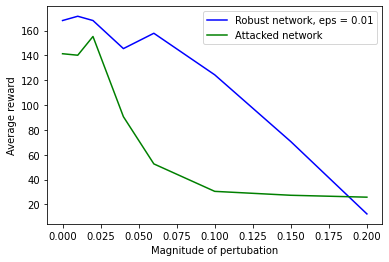

In [12]:
plt.figure(1)
plt.plot(epsilons_attacks,robust_average_rewards[0], "-b",label = "Robust network, eps = 0.01")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

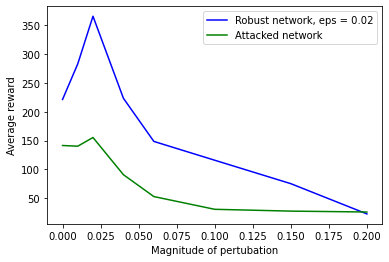

In [13]:
plt.figure(2)
plt.plot(epsilons_attacks,robust_average_rewards[1], "-b",label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

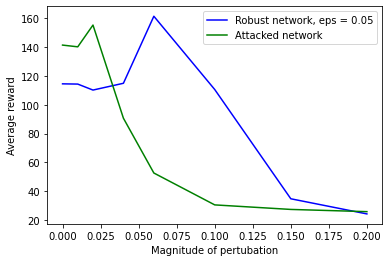

In [14]:
plt.figure(3)
plt.plot(epsilons_attacks,robust_average_rewards[2], "-b",label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

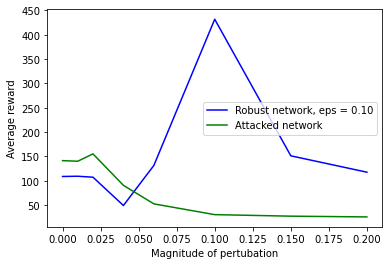

In [15]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[3], "-b",label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()